# Predicting Taxi Demand 

My Aim in this Project is to build models to predict the number of pick ups in a given amount of time and location. Compare the models and find out which one give accurate results.

# Data Information

Data has been obtained from https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page

I had Collected data regarding the New Yorkl Famous Yellow Taxi of December 2018 and December 2019

In [1]:
import pandas as pd
import numpy as np
import dask.dataframe as dd
import dask_xgboost as dxgb
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

Let us look at the data provided by NYC Taxi and Limousine commision

In [3]:
yelloCab_data2018 = dd.read_csv("YelloCab_2018_Dec.csv")

In [4]:
yelloCab_data2018.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,tip_amount,tolls_amount,improvement_surcharge,total_amount,Borough,Zone,Dropoff_Cordinates_lattitude,Dropoff_Cordinates_logitude,Pickup_Cordinates_lattitude,Pickup_Cordinates_logitude
0,1,2018-12-01 00:28:22,2018-12-01 00:44:07,2,2.5,1,N,148,234,1,...,3.95,0.0,0.3,17.25,Manhattan,Lower East Side,40.735909,-73.990163,40.717802,-73.985673
1,1,2018-12-01 00:52:29,2018-12-01 01:11:37,3,2.3,1,N,170,144,1,...,2.85,0.0,0.3,17.15,Manhattan,Murray Hill,40.722888,-73.994829,40.747629,-73.976774
2,2,2018-12-01 00:12:52,2018-12-01 00:36:23,1,0.0,1,N,113,193,2,...,0.00,0.0,0.3,3.80,Manhattan,Greenwich Village North,40.754495,-73.945613,40.735318,-73.994135
3,1,2018-12-01 00:35:08,2018-12-01 00:43:11,1,3.9,1,N,95,92,1,...,2.75,0.0,0.3,16.55,Queens,Forest Hills,40.763641,-73.830253,40.721512,-73.843931
4,1,2018-12-01 00:21:54,2018-12-01 01:15:13,1,12.8,1,N,163,228,1,...,9.25,0.0,0.3,55.55,Manhattan,Midtown North,40.644337,-74.007532,40.756061,-73.986950


Above data contains pick up and drop-off lattitude and logitude alon with zones

In [5]:
yelloCab_data2018.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'Borough', 'Zone', 'Dropoff_Cordinates_lattitude',
       'Dropoff_Cordinates_logitude', 'Pickup_Cordinates_lattitude',
       'Pickup_Cordinates_logitude'],
      dtype='object')

In [6]:
len(yelloCab_data2018)

7984546

In [7]:
print("No.of Columns= "+str(len(yelloCab_data2018.columns)))

No.of Columns= 23


By adding lattitude, longiture, borough and zone we got additional columns 

In [8]:
from graphviz import Digraph

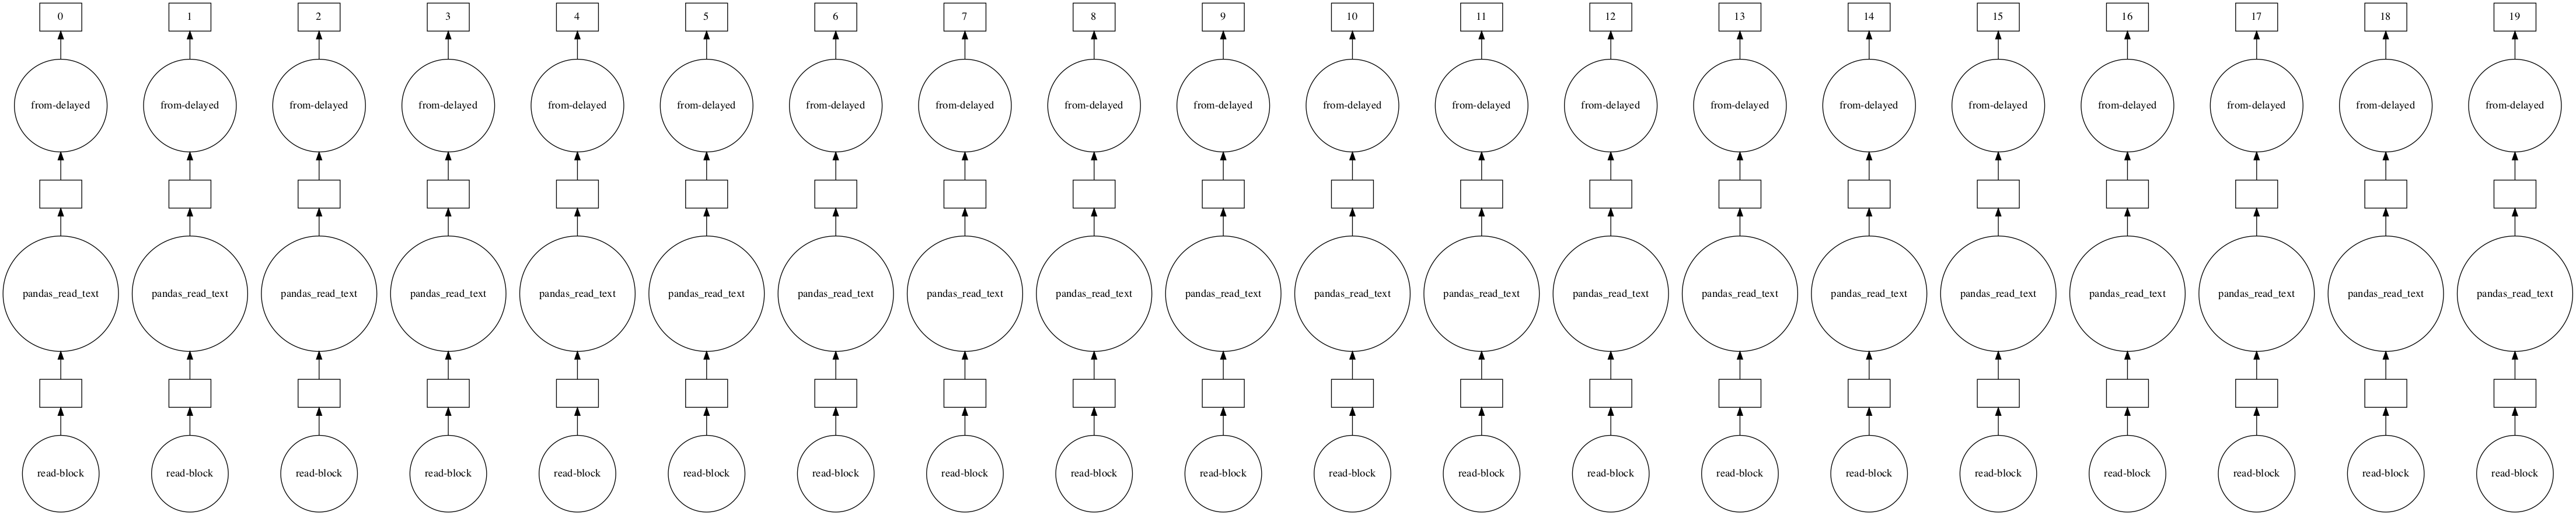

In [9]:
yelloCab_data2018.visualize()

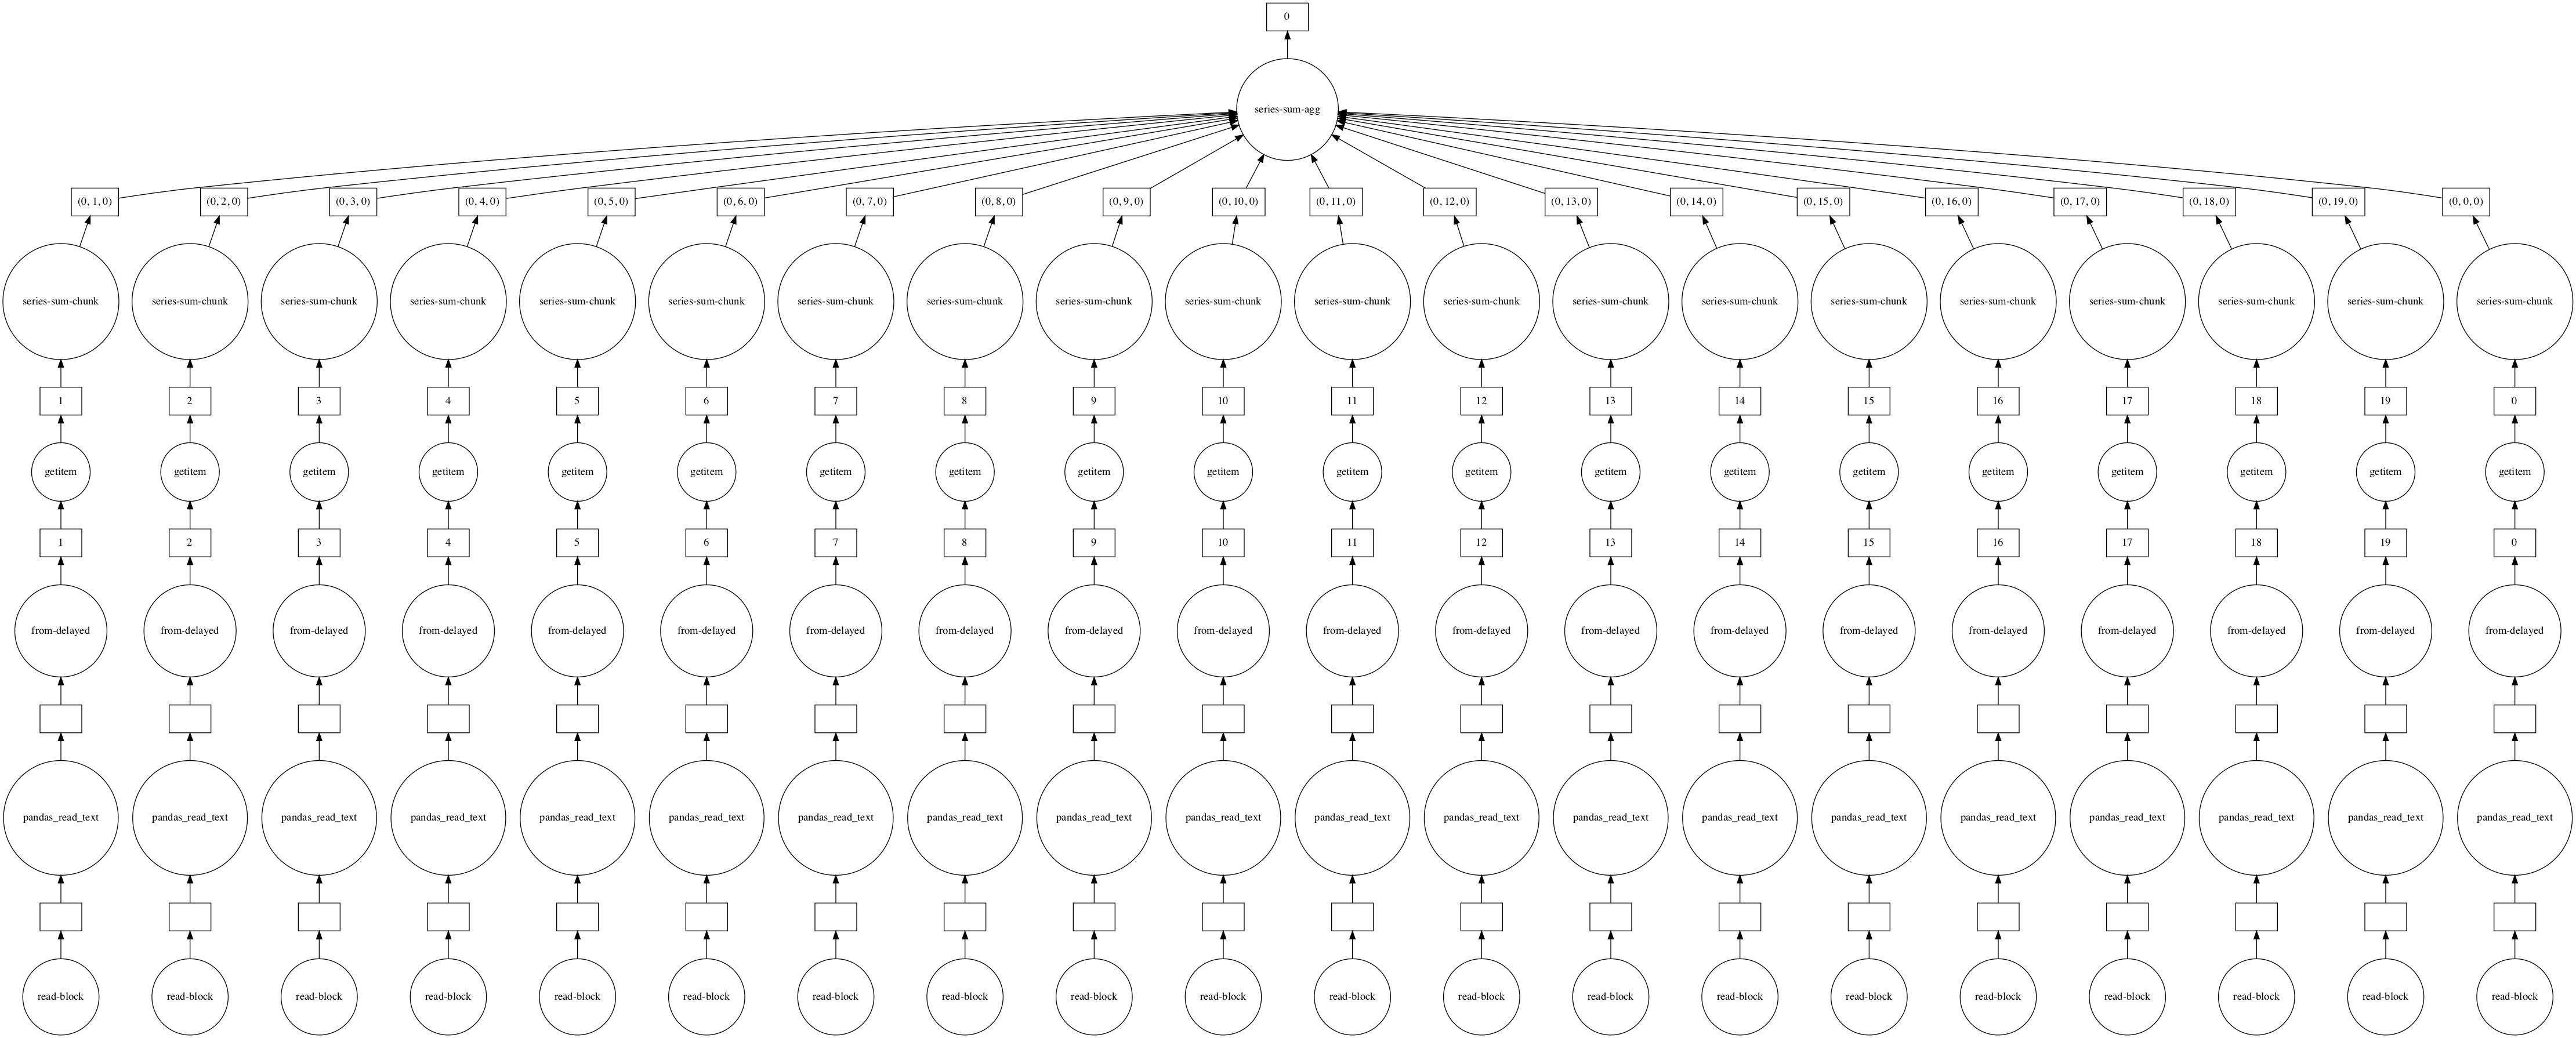

In [10]:
yelloCab_data2018.fare_amount.sum().visualize()

##Features in the dataset:
<table border="1">
	<tr>
		<th>Field Name</th>
		<th>Description</th>
	</tr>
	<tr>
		<td>VendorID</td>
		<td>
		A code indicating the TPEP provider that provided the record.
		<ol>
			<li>Creative Mobile Technologies</li>
			<li>VeriFone Inc.</li>
		</ol>
		</td>
	</tr>
	<tr>
		<td>tpep_pickup_datetime</td>
		<td>The date and time when the meter was engaged.</td>
	</tr>
	<tr>
		<td>tpep_dropoff_datetime</td>
		<td>The date and time when the meter was disengaged.</td>
	</tr>
	<tr>
		<td>Passenger_count</td>
		<td>The number of passengers in the vehicle. This is a driver-entered value.</td>
	</tr>
	<tr>
		<td>Trip_distance</td>
		<td>The elapsed trip distance in miles reported by the taximeter.</td>
	</tr>
	<tr>
		<td>RateCodeID</td>
		<td>The final rate code in effect at the end of the trip.
		<ol>
			<li> Standard rate </li>
			<li> JFK </li>
			<li> Newark </li>
			<li> Nassau or Westchester</li>
			<li> Negotiated fare </li>
			<li> Group ride</li>
		</ol>
		</td>
	</tr>
	<tr>
		<td>Store_and_fwd_flag</td>
		<td>This flag indicates whether the trip record was held in vehicle memory before sending to the vendor,<br\> aka “store and forward,” because the vehicle did not have a connection to the server.
		<br\>Y= store and forward trip
		<br\>N= not a store and forward trip
		</td>
	</tr>
     <tr>
		<td>PUlocationID</td>
		<td>Longitude where the meter was disengaged.</td>
	</tr>
     <tr>
		<td>DOLocationID</td>
		<td>Latitude where the meter was disengaged.</td>
	</tr>
    <tr>
		<td>Payment_type</td>
		<td>A numeric code signifying how the passenger paid for the trip.
		<ol>
			<li> Credit card </li>
			<li> Cash </li>
			<li> No charge </li>
			<li> Dispute </li>
			<li> Unknown </li>
			<li> Voided trip</li>
		</ol>
		</td>
	</tr>
    <tr>
		<td>Fare_amount</td>
		<td>The time-and-distance fare calculated by the meter.</td>
	</tr>
    <tr>
		<td>Extra</td>
		<td>Miscellaneous extras and surcharges. Currently, this only includes. the $0.50 and $1 rush hour and overnight charges..</td>
	</tr>
    <tr>
		<td>MTA_tax</td>
		<td>0.50 MTA tax that is automatically triggered based on the metered rate in use.</td>
	</tr>
    <tr>
		<td>Tip_amount</td>
		<td>Tip amount – This field is automatically populated for credit card tips.Cash tips are not included.</td>
	</tr>
    <tr>
		<td>Tolls_amount</td>
		<td>Total amount of all tolls paid in trip.</td>
	</tr>
     <tr>
		<td>Total_amount</td>
		<td>The total amount charged to passengers. Does not include cash tips.</td>
	</tr>
     <tr>
		<td>Pick-up Lattitude</td>
		<td>Geographical Lattitude ID for Pickup loation.</td>
	</tr>
     <tr>
		<td>Pick-up Logitude</td>
		<td>Geographical Logitude ID for Pickup loation.</td>
	</tr>
     <tr>
		<td>Drop-off Lattitude</td>
		<td>Geographical Lattitude ID for Pickup loation.</td>
	</tr>
     <tr>
		<td>Drop-off Logitude</td>
		<td>Geographical Logitude ID for Pickup loation.</td>
	</tr>
     <tr>
		<td>Borough</td>
		<td>Location Name</td>
	</tr>
    <tr>
		<td>Zone</td>
		<td>Zone Name</td>
	</tr>

In [11]:
yelloCab_data2018.dtypes

VendorID                          int64
tpep_pickup_datetime             object
tpep_dropoff_datetime            object
passenger_count                   int64
trip_distance                   float64
RatecodeID                        int64
store_and_fwd_flag               object
PULocationID                      int64
DOLocationID                      int64
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
Borough                          object
Zone                             object
Dropoff_Cordinates_lattitude    float64
Dropoff_Cordinates_logitude     float64
Pickup_Cordinates_lattitude     float64
Pickup_Cordinates_logitude      float64
dtype: object

In [12]:
yelloCab_data2018.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,Dropoff_Cordinates_lattitude,Dropoff_Cordinates_logitude,Pickup_Cordinates_lattitude,Pickup_Cordinates_logitude
npartitions=1,,,,,,,,,,,,,,,,,,
,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [11]:
print('Old size: %d' % len(yelloCab_data2018))

Old size: 7984546


In [12]:
yelloCab_data2018_NonzeroFare = yelloCab_data2018[yelloCab_data2018.fare_amount>=0]
print('New size: %d' % len(yelloCab_data2018_NonzeroFare))

New size: 7977712


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-whitegrid')

In [47]:
Yellocab_df=pd.read_csv("YelloCab_2018_Dec.csv")

In [17]:
Yellocab_df.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,Dropoff_Cordinates_lattitude,Dropoff_Cordinates_logitude,Pickup_Cordinates_lattitude,Pickup_Cordinates_logitude
count,7.984546e+06,7.984546e+06,7.984546e+06,7.984546e+06,7.984546e+06,7.984546e+06,7.984546e+06,7.984546e+06,7.984546e+06,7.984546e+06,7.984546e+06,7.984546e+06,7.984546e+06,7.984546e+06,7.984546e+06,7.984546e+06,7.984546e+06,7.984546e+06
mean,1.642261e+00,1.600368e+00,2.874887e+00,1.046938e+00,1.620975e+02,1.600753e+02,1.323132e+00,1.296545e+01,3.208622e-01,4.972410e-01,1.845838e+00,3.335392e-01,2.994155e-01,1.626687e+01,4.074918e+01,-7.393711e+01,4.074864e+01,-7.396663e+01
std,5.602575e-01,1.237852e+00,3.682711e+00,5.143034e-01,6.617796e+01,7.000680e+01,4.880915e-01,1.090268e+01,4.612815e-01,4.405518e-02,2.499524e+00,1.645239e+00,1.813828e-02,1.353535e+01,2.779239e-01,2.321236e+00,2.563752e-01,9.343405e-01
min,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,-3.000000e+02,-4.500000e+00,-5.000000e-01,-8.088000e+01,-3.133000e+01,-3.000000e-01,-3.003000e+02,1.850068e+01,-7.790272e+01,1.850068e+01,-7.790272e+01
25%,1.000000e+00,1.000000e+00,9.400000e-01,1.000000e+00,1.140000e+02,1.070000e+02,1.000000e+00,6.500000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,3.000000e-01,8.500000e+00,4.073532e+01,-7.399095e+01,4.073589e+01,-7.399095e+01
50%,2.000000e+00,1.000000e+00,1.600000e+00,1.000000e+00,1.620000e+02,1.620000e+02,1.000000e+00,9.500000e+00,0.000000e+00,5.000000e-01,1.360000e+00,0.000000e+00,3.000000e-01,1.180000e+01,4.075026e+01,-7.397844e+01,4.075026e+01,-7.398315e+01
75%,2.000000e+00,2.000000e+00,2.980000e+00,1.000000e+00,2.330000e+02,2.330000e+02,2.000000e+00,1.500000e+01,5.000000e-01,5.000000e-01,2.450000e+00,0.000000e+00,3.000000e-01,1.817000e+01,4.077370e+01,-7.396412e+01,4.077370e+01,-7.396412e+01
max,4.000000e+00,9.000000e+00,6.023000e+02,9.900000e+01,2.630000e+02,2.630000e+02,4.000000e+00,1.302000e+03,2.020000e+01,3.363000e+01,3.713700e+02,9.000100e+02,3.000000e-01,1.302800e+03,4.090098e+01,7.377873e+01,4.090098e+01,7.377873e+01


In [19]:
print('Old size: %d' % len(Yellocab_df))

Old size: 7984546


In [20]:
Yellocab_df_NonZero = Yellocab_df[Yellocab_df.fare_amount>=0]
print('New size: %d' % len(Yellocab_df_NonZero))

New size: 7977712


# Plotting Histogram for Fare

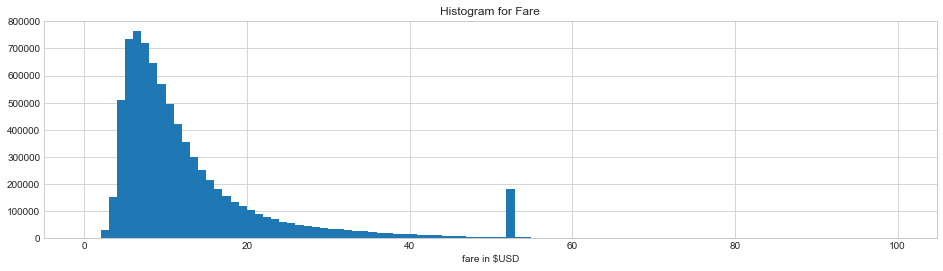

In [21]:
Yellocab_df_NonZero[Yellocab_df_NonZero.fare_amount<100].fare_amount.hist(bins=100, figsize=(16,4))
plt.xlabel('fare in $USD')
plt.title('Histogram for Fare');

Find NUll Values

In [22]:
print(Yellocab_df_NonZero.isnull().sum())

VendorID                        0
tpep_pickup_datetime            0
tpep_dropoff_datetime           0
passenger_count                 0
trip_distance                   0
RatecodeID                      0
store_and_fwd_flag              0
PULocationID                    0
DOLocationID                    0
payment_type                    0
fare_amount                     0
extra                           0
mta_tax                         0
tip_amount                      0
tolls_amount                    0
improvement_surcharge           0
total_amount                    0
Borough                         0
Zone                            0
Dropoff_Cordinates_lattitude    0
Dropoff_Cordinates_logitude     0
Pickup_Cordinates_lattitude     0
Pickup_Cordinates_logitude      0
dtype: int64


In [23]:
import datetime 

import time

In [24]:
Yellocab_df_NonZero.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,tip_amount,tolls_amount,improvement_surcharge,total_amount,Borough,Zone,Dropoff_Cordinates_lattitude,Dropoff_Cordinates_logitude,Pickup_Cordinates_lattitude,Pickup_Cordinates_logitude
0,1,2018-12-01 00:28:22,2018-12-01 00:44:07,2,2.5,1,N,148,234,1,...,3.95,0.0,0.3,17.25,Manhattan,Lower East Side,40.735909,-73.990163,40.717802,-73.985673
1,1,2018-12-01 00:52:29,2018-12-01 01:11:37,3,2.3,1,N,170,144,1,...,2.85,0.0,0.3,17.15,Manhattan,Murray Hill,40.722888,-73.994829,40.747629,-73.976774
2,2,2018-12-01 00:12:52,2018-12-01 00:36:23,1,0.0,1,N,113,193,2,...,0.00,0.0,0.3,3.80,Manhattan,Greenwich Village North,40.754495,-73.945613,40.735318,-73.994135
3,1,2018-12-01 00:35:08,2018-12-01 00:43:11,1,3.9,1,N,95,92,1,...,2.75,0.0,0.3,16.55,Queens,Forest Hills,40.763641,-73.830253,40.721512,-73.843931
4,1,2018-12-01 00:21:54,2018-12-01 01:15:13,1,12.8,1,N,163,228,1,...,9.25,0.0,0.3,55.55,Manhattan,Midtown North,40.644337,-74.007532,40.756061,-73.986950


In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

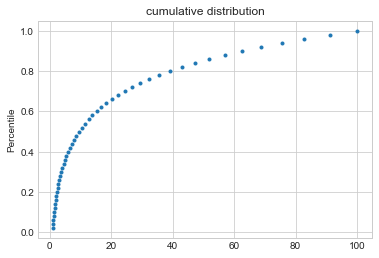

In [26]:
def ecdf(x):
    """Empirical cumulative distribution function of variable"""
    x = np.sort(x)
    n = len(x)
    y = np.arange(1, n + 1, 1) / n
    return x, y
xs, ys = ecdf(np.logspace(0, 2))
plt.plot(xs, ys, '.');
plt.ylabel('Percentile'); plt.title('cumulative distribution');

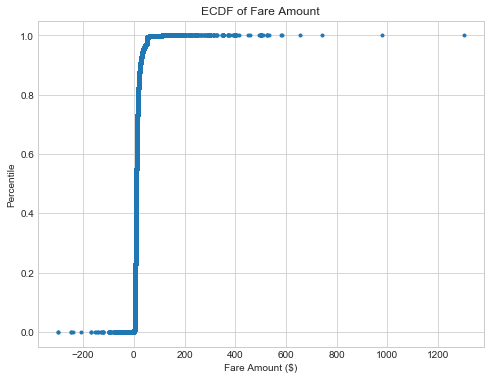

In [27]:
xs, ys = ecdf(Yellocab_df['fare_amount'])
plt.figure(figsize = (8, 6))
plt.plot(xs, ys, '.')
plt.ylabel('Percentile'); plt.title('ECDF of Fare Amount'); plt.xlabel('Fare Amount ($)');

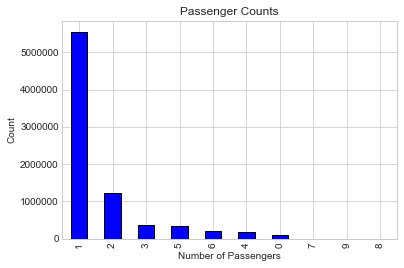

In [28]:
Yellocab_df['passenger_count'].value_counts().plot.bar(color = 'b', edgecolor = 'k');
plt.title('Passenger Counts'); plt.xlabel('Number of Passengers'); plt.ylabel('Count');

In [29]:
from scipy.stats import norm, kurtosis

In [30]:
Yellocab_df = norm.rvs(size=1000, random_state=3)

In [31]:
kurtosis(Yellocab_df)

-0.06928694200380558

In [32]:
import matplotlib.pyplot as plt
import scipy.stats as stats

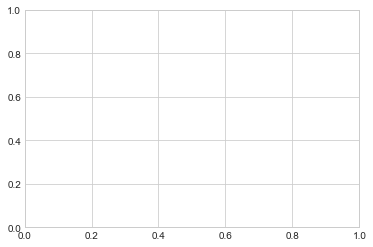

In [33]:
x = np.linspace(-5, 5, 100)
ax = plt.subplot()
distnames = ['laplace', 'norm', 'uniform']

In [34]:
for distname in distnames:
    if distname == 'uniform':
        dist = getattr(stats, distname)(loc=-2, scale=4)
    else:
        dist = getattr(stats, distname)
        data = dist.rvs(size=1000)
        kur = kurtosis(data, fisher=True)
        y = dist.pdf(x)
        ax.plot(x, y, label="{}, {}".format(distname, round(kur, 3)))
        ax.legend()

In [35]:
Yellocab_df_NonZero.skew()

VendorID                          0.621524
passenger_count                   2.194674
trip_distance                     4.056461
RatecodeID                      117.778019
PULocationID                     -0.270502
DOLocationID                     -0.323905
payment_type                      1.052676
fare_amount                       3.495403
extra                             4.509360
mta_tax                         112.718421
tip_amount                        6.480756
tolls_amount                     87.881181
improvement_surcharge           -64.929048
total_amount                      3.412403
Dropoff_Cordinates_lattitude    -78.892532
Dropoff_Cordinates_logitude      63.563387
Pickup_Cordinates_lattitude     -85.408904
Pickup_Cordinates_logitude      157.620612
dtype: float64

In [36]:
Yellocab_df_NonZero.kurtosis()

VendorID                             2.164010
passenger_count                      4.110279
trip_distance                      185.302217
RatecodeID                       21997.602759
PULocationID                        -0.905949
DOLocationID                        -0.954425
payment_type                         0.187451
fare_amount                         68.562740
extra                               69.871531
mta_tax                         124036.643974
tip_amount                         307.055982
tolls_amount                     38513.888675
improvement_surcharge             4213.782361
total_amount                        45.390286
Dropoff_Cordinates_lattitude      6322.632874
Dropoff_Cordinates_logitude       4041.152950
Pickup_Cordinates_lattitude       7412.570618
Pickup_Cordinates_logitude       24950.212509
dtype: float64

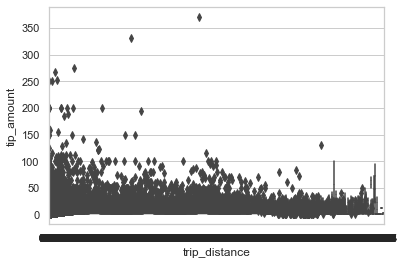

In [37]:
import seaborn as sns
sns.set(style="whitegrid")
ax = sns.boxplot(x="trip_distance", y="tip_amount", data=Yellocab_df_NonZero)

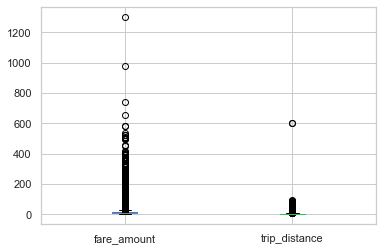

In [38]:
boxplot = Yellocab_df_NonZero.boxplot(column=['fare_amount','trip_distance'])

Text(0.5, 1.0, 'Distribution of Trip Fare')

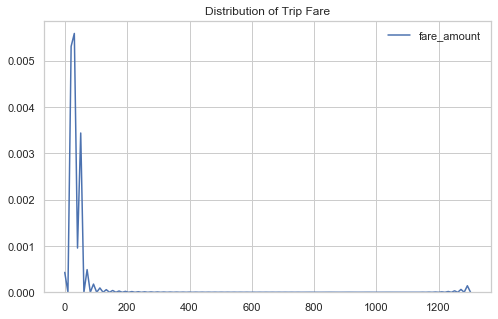

In [39]:
plt.figure(figsize=(8,5))
sns.kdeplot(Yellocab_df_NonZero['fare_amount']).set_title("Distribution of Trip Fare")

Text(0.5, 1.0, 'Trip Distance vs Fare Amount')

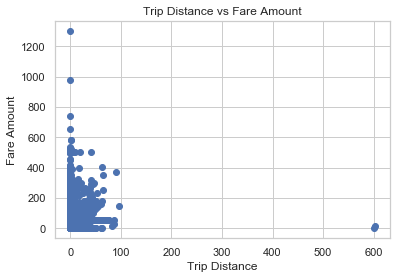

In [40]:
plt.scatter(x=Yellocab_df_NonZero['trip_distance'],y=Yellocab_df_NonZero['fare_amount'])
plt.xlabel("Trip Distance")
plt.ylabel("Fare Amount")
plt.title("Trip Distance vs Fare Amount")

/Users/manideepmaddipatla/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


Text(0.5, 1.0, 'Distribution of fare amount (log scale)')

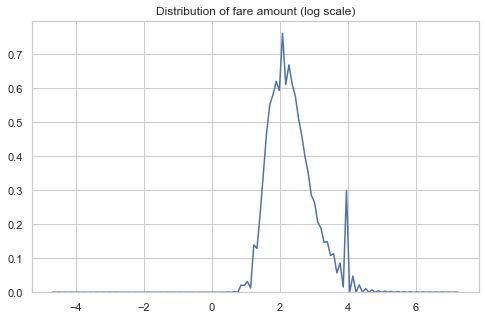

In [41]:
plt.figure(figsize=(8,5))
sns.kdeplot(np.log(Yellocab_df_NonZero['fare_amount'].values)).set_title("Distribution of fare amount (log scale)")

/Users/manideepmaddipatla/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


Text(0.5, 1.0, 'Distribution of Trip Distance (log scale)')

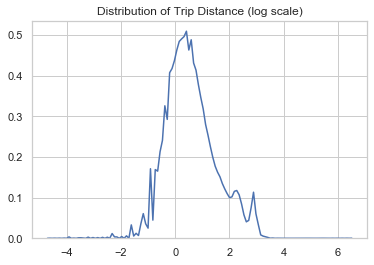

In [42]:
sns.kdeplot(np.log(Yellocab_df_NonZero['trip_distance'].values)).set_title("Distribution of Trip Distance (log scale)")

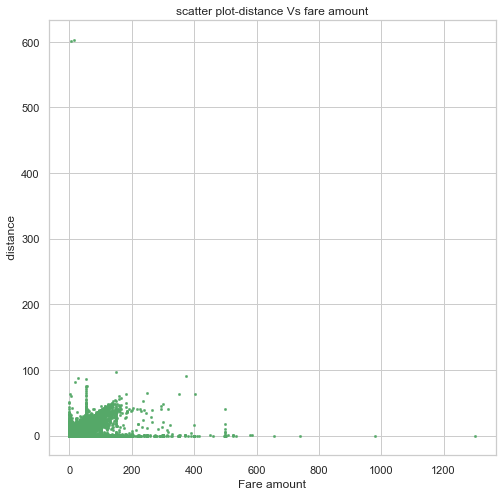

In [43]:
plt.figure(figsize = (8,8))

plt.scatter(Yellocab_df_NonZero["fare_amount"],
            Yellocab_df_NonZero["trip_distance"],s = 5,
            linewidths=0.5, c = "g")
plt.ylabel(" distance")
plt.xlabel("Fare amount")
plt.title("scatter plot-distance Vs fare amount")
plt.show()

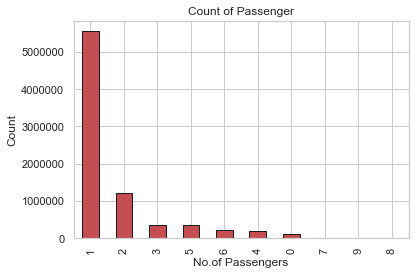

In [44]:
Yellocab_df_NonZero['passenger_count'].value_counts().plot.bar(color = 'r', edgecolor = 'k');
plt.title('Count of Passenger'); plt.xlabel('No.of Passengers'); plt.ylabel('Count');

# Analysing Missing Data and Outliers

In [48]:
Yellocab_df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,tip_amount,tolls_amount,improvement_surcharge,total_amount,Borough,Zone,Dropoff_Cordinates_lattitude,Dropoff_Cordinates_logitude,Pickup_Cordinates_lattitude,Pickup_Cordinates_logitude
0,1,2018-12-01 00:28:22,2018-12-01 00:44:07,2,2.5,1,N,148,234,1,...,3.95,0.0,0.3,17.25,Manhattan,Lower East Side,40.735909,-73.990163,40.717802,-73.985673
1,1,2018-12-01 00:52:29,2018-12-01 01:11:37,3,2.3,1,N,170,144,1,...,2.85,0.0,0.3,17.15,Manhattan,Murray Hill,40.722888,-73.994829,40.747629,-73.976774
2,2,2018-12-01 00:12:52,2018-12-01 00:36:23,1,0.0,1,N,113,193,2,...,0.00,0.0,0.3,3.80,Manhattan,Greenwich Village North,40.754495,-73.945613,40.735318,-73.994135
3,1,2018-12-01 00:35:08,2018-12-01 00:43:11,1,3.9,1,N,95,92,1,...,2.75,0.0,0.3,16.55,Queens,Forest Hills,40.763641,-73.830253,40.721512,-73.843931
4,1,2018-12-01 00:21:54,2018-12-01 01:15:13,1,12.8,1,N,163,228,1,...,9.25,0.0,0.3,55.55,Manhattan,Midtown North,40.644337,-74.007532,40.756061,-73.986950


In [49]:
print(Yellocab_df.isnull().sum())

VendorID                        0
tpep_pickup_datetime            0
tpep_dropoff_datetime           0
passenger_count                 0
trip_distance                   0
RatecodeID                      0
store_and_fwd_flag              0
PULocationID                    0
DOLocationID                    0
payment_type                    0
fare_amount                     0
extra                           0
mta_tax                         0
tip_amount                      0
tolls_amount                    0
improvement_surcharge           0
total_amount                    0
Borough                         0
Zone                            0
Dropoff_Cordinates_lattitude    0
Dropoff_Cordinates_logitude     0
Pickup_Cordinates_lattitude     0
Pickup_Cordinates_logitude      0
dtype: int64


There is no missing values in the given data

In [50]:
print('Old size: %d' % len(Yellocab_df))
Yellocab_df_NZ = Yellocab_df.dropna(how = 'any', axis = 'rows')
print('New size: %d' % len(Yellocab_df_NZ))

Old size: 7984546
New size: 7984546


In [51]:
Yellocab_df.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,Dropoff_Cordinates_lattitude,Dropoff_Cordinates_logitude,Pickup_Cordinates_lattitude,Pickup_Cordinates_logitude
count,7.984546e+06,7.984546e+06,7.984546e+06,7.984546e+06,7.984546e+06,7.984546e+06,7.984546e+06,7.984546e+06,7.984546e+06,7.984546e+06,7.984546e+06,7.984546e+06,7.984546e+06,7.984546e+06,7.984546e+06,7.984546e+06,7.984546e+06,7.984546e+06
mean,1.642261e+00,1.600368e+00,2.874887e+00,1.046938e+00,1.620975e+02,1.600753e+02,1.323132e+00,1.296545e+01,3.208622e-01,4.972410e-01,1.845838e+00,3.335392e-01,2.994155e-01,1.626687e+01,4.074918e+01,-7.393711e+01,4.074864e+01,-7.396663e+01
std,5.602575e-01,1.237852e+00,3.682711e+00,5.143034e-01,6.617796e+01,7.000680e+01,4.880915e-01,1.090268e+01,4.612815e-01,4.405518e-02,2.499524e+00,1.645239e+00,1.813828e-02,1.353535e+01,2.779239e-01,2.321236e+00,2.563752e-01,9.343405e-01
min,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,-3.000000e+02,-4.500000e+00,-5.000000e-01,-8.088000e+01,-3.133000e+01,-3.000000e-01,-3.003000e+02,1.850068e+01,-7.790272e+01,1.850068e+01,-7.790272e+01
25%,1.000000e+00,1.000000e+00,9.400000e-01,1.000000e+00,1.140000e+02,1.070000e+02,1.000000e+00,6.500000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,3.000000e-01,8.500000e+00,4.073532e+01,-7.399095e+01,4.073589e+01,-7.399095e+01
50%,2.000000e+00,1.000000e+00,1.600000e+00,1.000000e+00,1.620000e+02,1.620000e+02,1.000000e+00,9.500000e+00,0.000000e+00,5.000000e-01,1.360000e+00,0.000000e+00,3.000000e-01,1.180000e+01,4.075026e+01,-7.397844e+01,4.075026e+01,-7.398315e+01
75%,2.000000e+00,2.000000e+00,2.980000e+00,1.000000e+00,2.330000e+02,2.330000e+02,2.000000e+00,1.500000e+01,5.000000e-01,5.000000e-01,2.450000e+00,0.000000e+00,3.000000e-01,1.817000e+01,4.077370e+01,-7.396412e+01,4.077370e+01,-7.396412e+01
max,4.000000e+00,9.000000e+00,6.023000e+02,9.900000e+01,2.630000e+02,2.630000e+02,4.000000e+00,1.302000e+03,2.020000e+01,3.363000e+01,3.713700e+02,9.000100e+02,3.000000e-01,1.302800e+03,4.090098e+01,7.377873e+01,4.090098e+01,7.377873e+01


Here we can observe that ther is negative values in fare_amount, extra, mta_tax, tip_amount, toll_amount,improvement_surcharge and total_amount

In [52]:
print(f"Total Negative Fares are| {len(Yellocab_df[Yellocab_df['fare_amount'] < 0])}.")

Total Negative Fares are| 6834.


In [53]:
print(f"Total $0 Fares are| {len(Yellocab_df[Yellocab_df['fare_amount'] == 0])} .")


Total $0 Fares are| 1695 .


In [54]:
print(f"Total fares greater than $100 are|{len(Yellocab_df[Yellocab_df['fare_amount'] > 100])} .")

Total fares greater than $100 are|1297 .


count    7.984546e+06
mean     2.874887e+00
std      3.682711e+00
min      0.000000e+00
25%      9.400000e-01
50%      1.600000e+00
75%      2.980000e+00
max      6.023000e+02
Name: trip_distance, dtype: float64

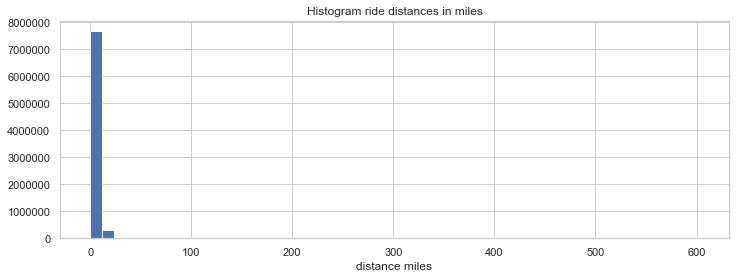

In [55]:
Yellocab_df.trip_distance.hist(bins=50, figsize=(12,4))
plt.xlabel('distance miles')
plt.title('Histogram ride distances in miles')
Yellocab_df.trip_distance.describe()

We can see here that most of the ride are short ones 

In [56]:
Yellocab_df.groupby('passenger_count')['trip_distance', 'fare_amount'].mean()

,trip_distance,fare_amount
passenger_count,,
0,2.760265,12.919367
1,2.835449,12.820339
2,2.997985,13.431918
3,2.930534,13.246695
4,2.987982,13.588087
5,2.966334,13.064121
6,2.920707,12.936866
7,2.519444,33.433333
8,2.612308,47.344615


Above table shows that the passenger count is zero and means trip_distance and Fare_amount is greater than zero which does not looks good. But it might be some transportation of goods . So comparing fare per mile to see some insignts

In [57]:
print("Avg $USD/Mile : {:0.2f}".format(Yellocab_df.fare_amount.sum()/Yellocab_df.trip_distance.sum()))

Avg $USD/Mile : 4.51


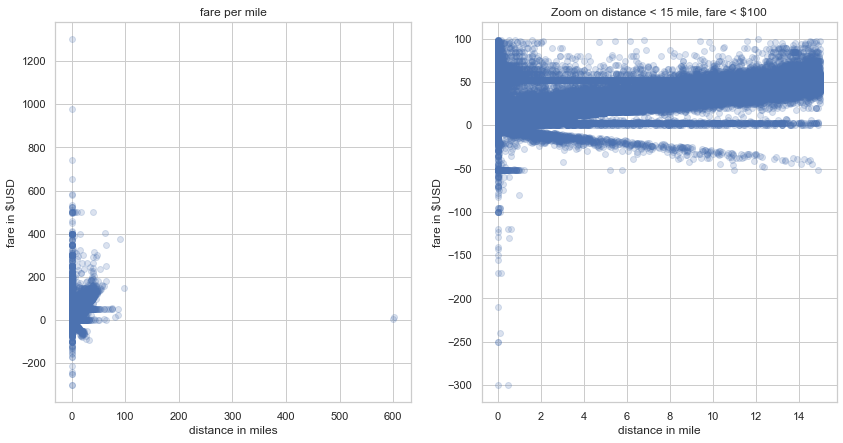

In [58]:
# scatter plot distance - fare
fig, axs = plt.subplots(1, 2, figsize=(14,7))
axs[0].scatter(Yellocab_df.trip_distance, Yellocab_df.fare_amount, alpha=0.2)
axs[0].set_xlabel('distance in miles')
axs[0].set_ylabel('fare in $USD')
axs[0].set_title('fare per mile')
# zoom in on part of data
idx = (Yellocab_df.trip_distance < 15) & (Yellocab_df.fare_amount < 100)
axs[1].scatter(Yellocab_df[idx].trip_distance, Yellocab_df[idx].fare_amount, alpha=0.2)
axs[1].set_xlabel('distance in mile')
axs[1].set_ylabel('fare in $USD')
axs[1].set_title('Zoom on distance < 15 mile, fare < $100');

# Data cleaning

# Pick-up Lattitude and logitude

In [14]:

import dask.dataframe as dd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import folium
import gpxpy.geo
from datetime import datetime


In [15]:
outlier_locations = yelloCab_data2018[((yelloCab_data2018.Pickup_Cordinates_logitude <= -74.15) | (yelloCab_data2018.Pickup_Cordinates_lattitude <= 40.5774)| (yelloCab_data2018.Pickup_Cordinates_logitude >= -73.7004) | (yelloCab_data2018.Pickup_Cordinates_lattitude >= 40.9176))]

In [60]:
#outlier_locations = yelloCab_data2018[((yelloCab_data2018.Pickup_Cordinates_lattitude <= 40.5774) | (yelloCab_data2018.Pickup_Cordinates_logitude <= -74.15) | (yelloCab_data2018.Pickup_Cordinates_lattitude >= 40.9176) | (yelloCab_data2018.Pickup_Cordinates_logitude >= -73.7004))]

After some reasearch i founf that the new york city is bound with the following lattitude and logitude(40.5774, -74.15) & (40.9176,-73.7004) hence i marked all point outside this are as outliers

In [16]:
mapos = folium.Map(location=[40.734695, -73.990372],zoom_start=15, tiles='Stamen Terrain')

outside_dropoff = outlier_locations.head(20000)

for i,j in outside_dropoff.iterrows():
    if j['Pickup_Cordinates_lattitude'] != 0:
        folium.Marker(list((j['Pickup_Cordinates_lattitude'],j['Pickup_Cordinates_logitude']))).add_to(mapos)
mapos

# Drop-off Location

In [17]:
drop_outlier_locations = yelloCab_data2018[((yelloCab_data2018.Dropoff_Cordinates_logitude <= -74.15) | (yelloCab_data2018.Dropoff_Cordinates_lattitude <= 40.5774)| \
                   (yelloCab_data2018.Dropoff_Cordinates_logitude >= -73.7004) | (yelloCab_data2018.Dropoff_Cordinates_lattitude >= 40.9176))]

In [18]:
maposd = folium.Map(location=[40.734695, -73.990372], zoom_start=15, tiles='Stamen Terrain')

drop_sample_locations = drop_outlier_locations.head(20000)

for i,j in drop_sample_locations.iterrows():
    if int(j['Dropoff_Cordinates_lattitude']) != 0:
        folium.Marker(list((j['Dropoff_Cordinates_lattitude'],j['Dropoff_Cordinates_logitude']))).add_to(maposd)
maposd

# #Trip Duration

Converting Timestamps to unix to get trip duration and speed aswell as pick up time which are used during binning

In [24]:
import datetime 

import time

In [29]:
def convert_to_unix(t):
    return time.mktime(datetime.datetime.strptime(t, "%Y-%m-%d %H:%M:%S").timetuple())
def trip_time_return(df):
    #startTime = datetime.now()
    duration = df[["tpep_pickup_datetime", "tpep_dropoff_datetime"]].compute()
    duration_pickup = [convert_to_unix(pkup) for pkup in duration["tpep_pickup_datetime"].values]
    duration_drop = [convert_to_unix(drpof) for drpof in duration["tpep_dropoff_datetime"].values]
    durations = (np.array(duration_drop) - np.array(duration_pickup))/float(60)  
    NewFrame = df[['passenger_count','trip_distance','Pickup_Cordinates_logitude','Pickup_Cordinates_lattitude','Dropoff_Cordinates_logitude','Dropoff_Cordinates_lattitude','total_amount']].compute()
    NewFrame["trip_times"] = durations
    NewFrame["pickup_times"] = duration_pickup
    NewFrame["Speed"] = (NewFrame["trip_distance"]/NewFrame["trip_times"])*60  
    #print("Time taken for creation of dataframe is {}".format(datetime.now() - startTime))
    return NewFrame

In [145]:
def convert_to_unix(s):
    return time.mktime(datetime.datetime.strptime(s, "%Y-%m-%d %H:%M:%S").timetuple())
def trip_time_return(month):
    duration = month[['tpep_pickup_datetime','tpep_dropoff_datetime']].compute()
    duration_pickup = [convert_to_unix(x) for x in duration['tpep_pickup_datetime'].values]
    duration_drop = [convert_to_unix(x) for x in duration['tpep_dropoff_datetime'].values]
    durations = (np.array(duration_drop) - np.array(duration_pickup))/float(60)
    new_frame = yelloCab_data2018[['passenger_count','trip_distance','Pickup_Cordinates_logitude','Pickup_Cordinates_lattitude','Dropoff_Cordinates_logitude','Dropoff_Cordinates_lattitude','total_amount']].compute()
    new_frame['trip_times'] = durations
    new_frame['pickup_times'] = duration_pickup
    new_frame['Speed'] = 60*(new_frame['trip_distance']/new_frame['trip_times'])
    return new_frame

In [30]:
new_yelloCab_data2018 = trip_time_return(yelloCab_data2018)

# Below skewed box plot shows us the presence of outliers 

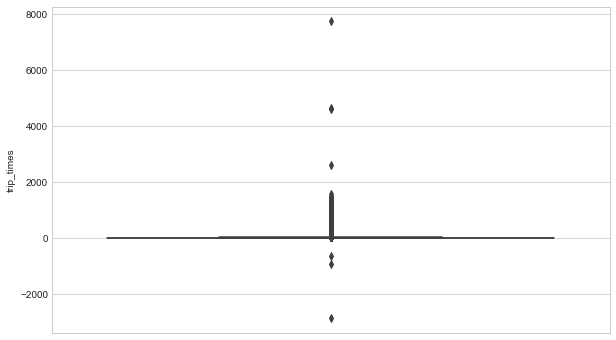

In [31]:
#matplotlib.use('nbagg')
#import matplotlib.pylab as plt
import seaborn as sns
plt.figure(figsize = (10,6))
sns.boxplot("trip_times", data = new_yelloCab_data2018, orient = "v")
plt.show()

In [32]:
#Calculate percentile to remove outliers
for i in range(0,100,10):
    var =new_yelloCab_data2018["trip_times"].values
    var = np.sort(var,axis = None)
    print("{}th percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

0th percentile value is -2846.0333333333333
10th percentile value is 4.033333333333333
20th percentile value is 5.8
30th percentile value is 7.516666666666667
40th percentile value is 9.383333333333333
50th percentile value is 11.483333333333333
60th percentile value is 14.0
70th percentile value is 17.183333333333334
80th percentile value is 21.683333333333334
90th percentile value is 29.566666666666666
100 percentile value is  7720.35


In [33]:
for i in range(90,100):
    var =new_yelloCab_data2018["trip_times"].values
    var = np.sort(var,axis = None)
    print("{}th percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

90th percentile value is 29.566666666666666
91th percentile value is 30.816666666666666
92th percentile value is 32.233333333333334
93th percentile value is 33.86666666666667
94th percentile value is 35.8
95th percentile value is 38.166666666666664
96th percentile value is 41.21666666666667
97th percentile value is 45.416666666666664
98th percentile value is 51.7
99th percentile value is 63.88333333333333
100 percentile value is  7720.35


We can see that 0th percentile value is in negative and also 99th percentile of trip is 63.88 min but we can also see that 100th percentile is 7720.35min which is too much high from 99th percentile and which is error points. So below i am removing such points
So According to the NYC taxi rule the maximum trip should be within 24 hours duration and one driver should drive only 12hours in 24 hrs interval but we can see there are some with negative values and some are 7720 minutes so all these should be removed

In [34]:
frame_with_modified_durations=new_yelloCab_data2018[(new_yelloCab_data2018.trip_times>1) & (new_yelloCab_data2018.trip_times<720)]

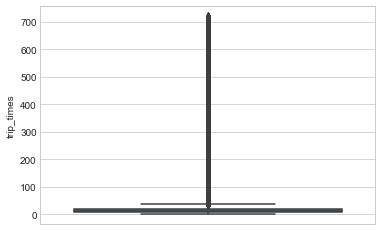

In [35]:
sns.boxplot(y="trip_times", data =frame_with_modified_durations)
plt.show()

In [36]:
import datetime
import time
import matplotlib.pylab as plt
%matplotlib inline
import seaborn as sns
import numpy as np

# As per the law of new york taxi comission, maximum trip duration allowed is 12 hours in 24 hours time period

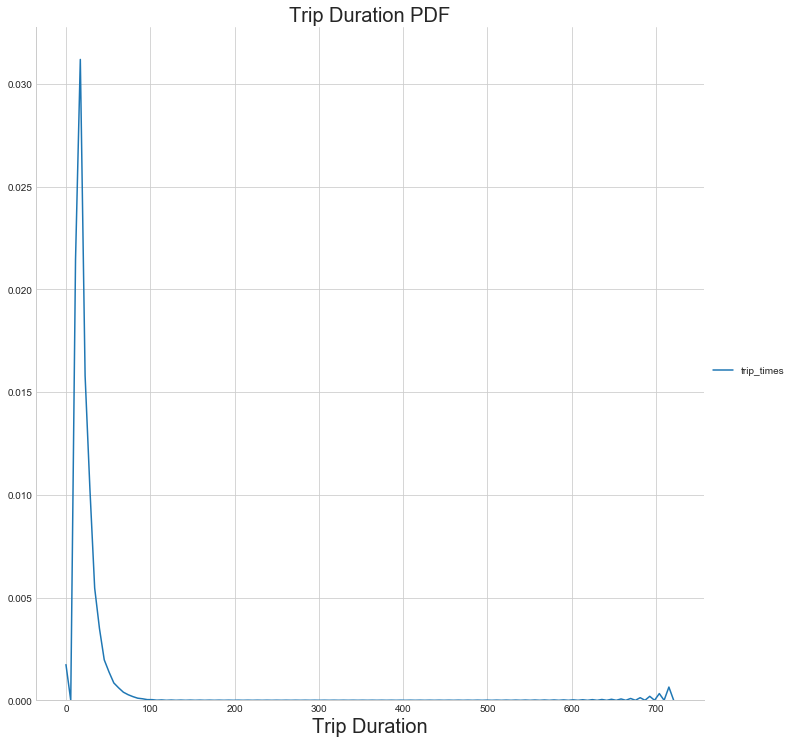

In [36]:
sns.FacetGrid(frame_with_modified_durations,size=10) \
      .map(sns.kdeplot,"trip_times") \
      .add_legend();
plt.xlabel("Trip Duration", fontsize = 20)
plt.title("Trip Duration PDF", fontsize = 20)
plt.show()
plt.show();

Above i am trying to retain the data with time greater than 1 minute and less than or equal to 720 minutes (12hr)

In [37]:
#converting the values to log-values to chec for log-normal
import math
frame_with_modified_durations['log_times']=[math.log(i) for i in frame_with_modified_durations['trip_times'].values]

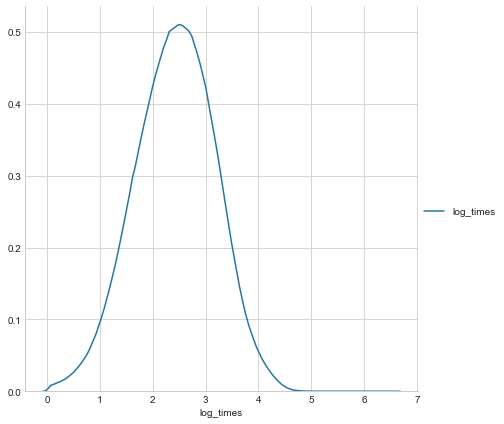

In [38]:
sns.FacetGrid(frame_with_modified_durations,size=6) \
      .map(sns.kdeplot,"log_times") \
      .add_legend();
plt.show();

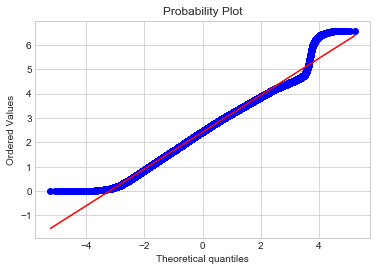

In [39]:
import scipy.integrate as integrate
import scipy
scipy.stats.probplot(frame_with_modified_durations['log_times'].values, plot=plt)
plt.show()

In [40]:
print(yelloCab_data2018.isnull().count())

Dask Series Structure:
npartitions=1
Borough          int64
trip_distance      ...
dtype: int64
Dask Name: dataframe-count-agg, 101 tasks


In [41]:
new_yelloCab_data2018.head()

,passenger_count,trip_distance,Pickup_Cordinates_logitude,Pickup_Cordinates_lattitude,Dropoff_Cordinates_logitude,Dropoff_Cordinates_lattitude,total_amount,trip_times,pickup_times,Speed
0,2,2.5,-73.985673,40.717802,-73.990163,40.735909,17.25,15.750000,1.543642e+09,9.523810
1,3,2.3,-73.976774,40.747629,-73.994829,40.722888,17.15,19.133333,1.543644e+09,7.212544
2,1,0.0,-73.994135,40.735318,-73.945613,40.754495,3.80,23.516667,1.543641e+09,0.000000
3,1,3.9,-73.843931,40.721512,-73.830253,40.763641,16.55,8.050000,1.543643e+09,29.068323
4,1,12.8,-73.986950,40.756061,-74.007532,40.644337,55.55,53.316667,1.543642e+09,14.404501


In [42]:
len(yelloCab_data2018)

7984546

In [80]:
outlier_RateCode = yelloCab_data2018[(yelloCab_data2018.RatecodeID > 6)]

In [81]:
len(outlier_RateCode)

133

In [82]:
outlier_fare_amount = yelloCab_data2018[(yelloCab_data2018.fare_amount < 0)]
len(outlier_fare_amount)

6834

In [83]:
outlier_extra = yelloCab_data2018[(yelloCab_data2018.extra < 0)]
len(outlier_extra)

3297

In [84]:
outlier_mta_tax= yelloCab_data2018[(yelloCab_data2018.mta_tax < 0)]
len(outlier_mta_tax)

6667

In [85]:
outlier_tip_amount= yelloCab_data2018[(yelloCab_data2018.tip_amount < 0)]
len(outlier_tip_amount)

73

In [86]:
outlier_toll_amount= yelloCab_data2018[(yelloCab_data2018.tolls_amount < 0)]
len(outlier_toll_amount)

115

In [87]:
outlier_improvement_surcharge= yelloCab_data2018[(yelloCab_data2018.improvement_surcharge< 0)]
len(outlier_improvement_surcharge)

6831

# Outlier detection in Speed

In [43]:
def labelchangespeed(num):
    if num < 10**3:
        return num
    elif num>=10**3 and num < 10**6:
        return str(num/10**3)+"k"
    elif num>=10**6 and num < 10**9:
        return str(num/10**6) + "M"
    else:
        return str(num/10**9) + "B"

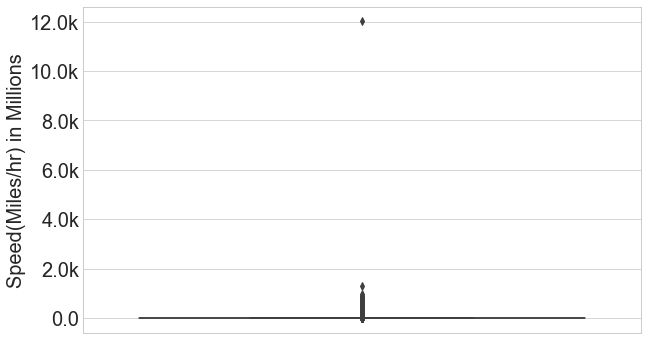

In [46]:
fig = plt.figure(figsize = (10,6))
ax = sns.boxplot("Speed", data = frame_with_modified_durations, orient = "v")

ax.set_yticklabels([labelchangespeed(num) for num in ax.get_yticks()])
plt.tick_params(labelsize = 20)
plt.ylabel("Speed(Miles/hr) in Millions", fontsize = 20)
plt.show()

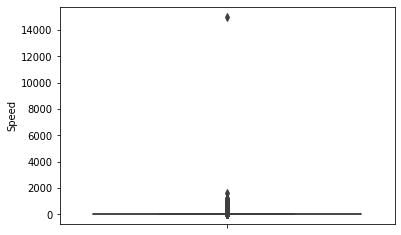

In [43]:
frame_with_modified_durations['Speed'] = 60*(frame_with_modified_durations['trip_distance']/frame_with_modified_durations['trip_times'])
sns.boxplot(y="Speed", data =frame_with_modified_durations)
plt.show()

In [52]:
#speed value with percentile calculation 0 to 100
for i in range(0,100,10):
    var =frame_with_modified_durations["Speed"].values
    var = np.sort(var,axis = None)
    print("{}th percentile value is {} mi/hr".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0th percentile value is 0.0 mi/hr
10th percentile value is 4.894009216589861 mi/hr
20th percentile value is 6.278544542032622 mi/hr
30th percentile value is 7.411764705882352 mi/hr
40th percentile value is 8.480889506601807 mi/hr
50th percentile value is 9.581749049429657 mi/hr
60th percentile value is 10.812720848056538 mi/hr
70th percentile value is 12.33404710920771 mi/hr
80th percentile value is 14.524239934264584 mi/hr
90th percentile value is 18.646502835538755 mi/hr
100 percentile value is  15012.5


In [53]:
#speed value with percentile calculation 90 to 100 here i am zooming to make sure the outliers and delete 
for i in range(90,100):
    var =frame_with_modified_durations["Speed"].values
    var = np.sort(var,axis = None)
    print("{}th percentile value is {} mi/hr".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

90th percentile value is 18.646502835538755 mi/hr
91th percentile value is 19.32046332046332 mi/hr
92th percentile value is 20.080560420315233 mi/hr
93th percentile value is 20.95295536791315 mi/hr
94th percentile value is 21.97722095671982 mi/hr
95th percentile value is 23.18002628120894 mi/hr
96th percentile value is 24.631578947368425 mi/hr
97th percentile value is 26.501766784452297 mi/hr
98th percentile value is 29.116193961573654 mi/hr
99th percentile value is 33.23356926188069 mi/hr
100 percentile value is  15012.5


In [54]:
#speed value with percentile calculation 90.0 to 100.0
for i in np.arange(0.0, 1.0, 0.1):
    var =frame_with_modified_durations["Speed"].values
    var = np.sort(var,axis = None)
    print("{}th percentile value is {} mi/hr".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0th percentile value is 33.23356926188069 mi/hr
99.1th percentile value is 33.80790960451977 mi/hr
99.2th percentile value is 34.43877551020408 mi/hr
99.3th percentile value is 35.13762329732269 mi/hr
99.4th percentile value is 35.93728222996515 mi/hr
99.5th percentile value is 36.82228412256267 mi/hr
99.6th percentile value is 37.86301369863014 mi/hr
99.7th percentile value is 39.172614712308814 mi/hr
99.8th percentile value is 40.87082405345212 mi/hr
99.9th percentile value is 43.46543778801844 mi/hr
100 percentile value is  15012.5


Observations: 
Above, 100th percentile value of a speed is 15012.5 miles/hr which is impossible
99.9th percentile value of speed is 43.46 mi/hr. 
So, removing all the data points where speed is greater than 43.46 miles/hr.

In [55]:
#removing further outliers based on the 99.9th percentile value
frame_with_modified_durations=frame_with_modified_durations[(frame_with_modified_durations.Speed>0) & (frame_with_modified_durations.Speed<43.46)]

# Box Plot speed after outliers are removed

Average speed of taxi in new york

In [59]:
avg_speed = sum(frame_with_modified_durations["Speed"]) / float(len(frame_with_modified_durations["Speed"]))
print(avg_speed)

10.92473597890942


So the average speed in NYC is 10.92 miles/hr which means cab driver can travel 1.66 mile in 10 min 

In [60]:
print("Speed of Taxis around NYC for every 10 minutes = "+str(avg_speed/6)+" per 10 minutes.")

Speed of Taxis around NYC for every 10 minutes = 1.8207893298182365 per 10 minutes.


# average speed in NYC is 10.92 miles/hr so for every 10 minutes cab driver can travel 1.82 mile

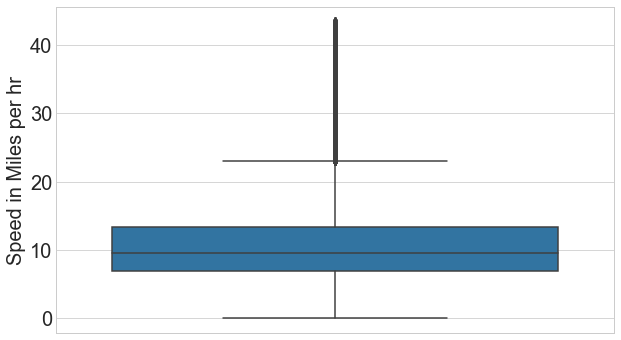

In [57]:
fig = plt.figure(figsize = (10,6))
ax = sns.boxplot("Speed", data = frame_with_modified_durations, orient = "v")

plt.tick_params(labelsize = 20)
plt.ylabel("Speed in Miles per hr", fontsize = 20)
plt.show()

# Outliers in  Trip Distance

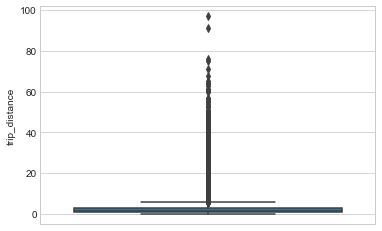

In [58]:
sns.boxplot(y="trip_distance", data =frame_with_modified_durations)
plt.show()

calculating trip_distance at 0 to 100 percentile 

In [63]:
for i in range(0,100,10):
    var =frame_with_modified_durations["trip_distance"].values
    var = np.sort(var,axis = None)
    print("{}th percentile value is {} miles".format(i,var[int(len(var)*(float(i)/100))]))
print("100th percentile value is ",var[-1])

0th percentile value is 0.01 miles
10th percentile value is 0.61 miles
20th percentile value is 0.85 miles
30th percentile value is 1.08 miles
40th percentile value is 1.3 miles
50th percentile value is 1.6 miles
60th percentile value is 2.0 miles
70th percentile value is 2.55 miles
80th percentile value is 3.6 miles
90th percentile value is 6.7 miles
100th percentile value is  96.94


calculating trip_distance at 90 to 100 percentile

In [64]:
for i in range(90,100):
    var =frame_with_modified_durations["trip_distance"].values
    var = np.sort(var,axis = None)
    print("{}th percentile value is {} miles".format(i,var[int(len(var)*(float(i)/100))]))
print("100th percentile value is ",var[-1])

90th percentile value is 6.7 miles
91th percentile value is 7.39 miles
92th percentile value is 8.17 miles
93th percentile value is 8.93 miles
94th percentile value is 9.7 miles
95th percentile value is 10.6 miles
96th percentile value is 11.8 miles
97th percentile value is 14.4 miles
98th percentile value is 17.15 miles
99th percentile value is 18.7 miles
100th percentile value is  96.94


calculating trip_distance at 99 to 100 percentile

In [65]:
for i in np.arange(0.0, 1.0, 0.1):
    var =frame_with_modified_durations["trip_distance"].values
    var = np.sort(var,axis = None)
    print("{}th percentile value is {} miles".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100th percentile value is ",var[-1])

99.0th percentile value is 18.7 miles
99.1th percentile value is 18.9 miles
99.2th percentile value is 19.17 miles
99.3th percentile value is 19.47 miles
99.4th percentile value is 19.8 miles
99.5th percentile value is 20.23 miles
99.6th percentile value is 20.7 miles
99.7th percentile value is 21.22 miles
99.8th percentile value is 21.99 miles
99.9th percentile value is 24.1 miles
100th percentile value is  96.94


Removing outliers based on 99th percentile

Observation: Here, 99.9th percentile of trip distance is 24.1 miles.
100th percentile value is 96.94 miles, which is very high.Removing all the data points where trip distance is greater than 24.1miles.

In [66]:
frame_with_modified_durations=frame_with_modified_durations[(frame_with_modified_durations.trip_distance>0) & (frame_with_modified_durations.trip_distance<25)]

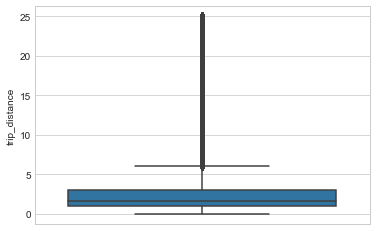

In [67]:
sns.boxplot(y="trip_distance", data = frame_with_modified_durations)
plt.show()

# Outliers in Total Fare

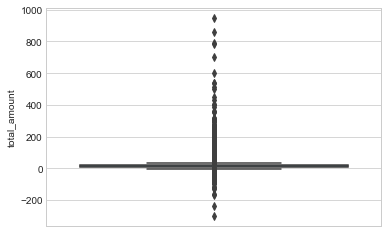

In [68]:
sns.boxplot(y="total_amount", data =frame_with_modified_durations)
plt.show()

Calculating total fare values with 0 to 100 th percentile

In [71]:
for i in range(0,100,10):
    var = frame_with_modified_durations["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value of fare is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value of fare is -300.3
10 percentile value of fare is 6.8
20 percentile value of fare is 7.88
30 percentile value of fare is 9.3
40 percentile value of fare is 10.55
50 percentile value of fare is 11.84
60 percentile value of fare is 13.8
70 percentile value of fare is 16.3
80 percentile value of fare is 20.3
90 percentile value of fare is 29.76
100 percentile value is  946.31


Calculating total fare values with 90 to 100 th percentile

In [72]:
for i in range(90,100):
    var = frame_with_modified_durations["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value of fare is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

90 percentile value of fare is 29.76
91 percentile value of fare is 31.8
92 percentile value of fare is 34.55
93 percentile value of fare is 37.55
94 percentile value of fare is 40.86
95 percentile value of fare is 44.75
96 percentile value of fare is 49.56
97 percentile value of fare is 55.87
98 percentile value of fare is 62.47
99 percentile value of fare is 70.27
100 percentile value is  946.31


Calculating total fare values with 99 to 100 th percentile

In [73]:
for i in np.arange(0.0, 1.0, 0.1):
    var = frame_with_modified_durations["total_amount"].values
    var = np.sort(var,axis = None)
    print("{} percentile value of fare is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value of fare is 70.27
99.1 percentile value of fare is 70.27
99.2 percentile value of fare is 70.27
99.3 percentile value of fare is 70.27
99.4 percentile value of fare is 72.52
99.5 percentile value of fare is 73.2
99.6 percentile value of fare is 75.66
99.7 percentile value of fare is 76.11
99.8 percentile value of fare is 81.3
99.9 percentile value of fare is 94.75
100 percentile value is  946.31


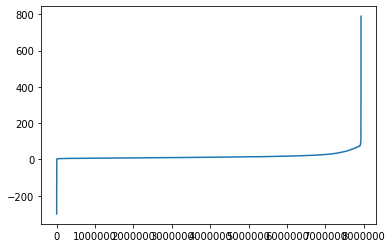

In [60]:
plt.plot(var[:-2])
plt.show()

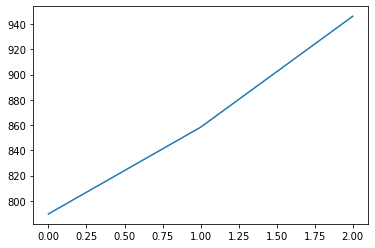

In [61]:
plt.plot(var[-3:])
plt.show()

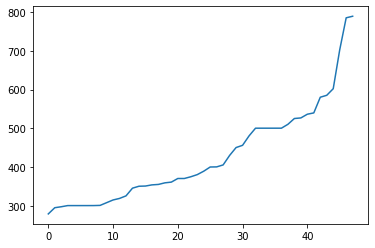

In [62]:
plt.plot(var[-50:-2])
plt.show()

Observation: Above we can see that, 99.9th percentile fare amount of a trip is 95.46. 
100th percentile of a fare amount is 946.31.removing the data points where fare amount is more than 99.9th percentile value.

In [74]:
frame_with_modified_durations= frame_with_modified_durations[(frame_with_modified_durations.total_amount>0) & (frame_with_modified_durations.total_amount<500)]

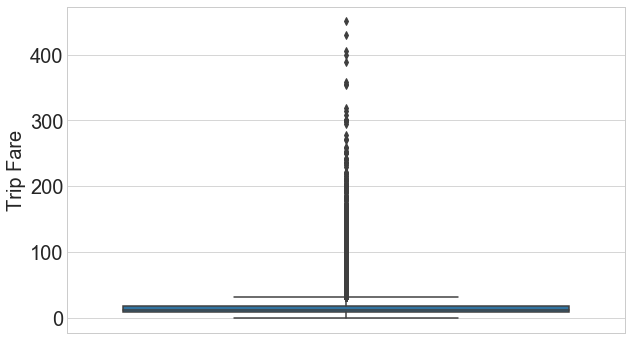

In [76]:
fig = plt.figure(figsize = (10,6))
ax = sns.boxplot("total_amount", data = frame_with_modified_durations, orient = "v")

plt.tick_params(labelsize = 20)
plt.ylabel("Trip Fare", fontsize = 20)
plt.show()

# Removing All outliers and error points

In [77]:
def removing_outliers(new_data_frame):

    
    a = new_data_frame.shape[0]
    print ("Number of pickup records = ",a)
    frame_temp = new_data_frame[((new_data_frame.Dropoff_Cordinates_logitude >= -74.15) & (new_data_frame.Dropoff_Cordinates_logitude <= -73.7004) &\
                       (new_data_frame.Dropoff_Cordinates_lattitude >= 40.5774) & (new_data_frame.Dropoff_Cordinates_lattitude <= 40.9176)) & \
                       ((new_data_frame.Pickup_Cordinates_logitude >= -74.15) & (new_data_frame.Pickup_Cordinates_lattitude >= 40.5774)& \
                       (new_data_frame.Pickup_Cordinates_logitude <= -73.7004) & (new_data_frame.Pickup_Cordinates_lattitude <= 40.9176))]
    b = frame_temp.shape[0]
    print ("No.of outlier coordinates lying outside NY boundaries:",(a-b))

    
    frame_temp = new_data_frame[(new_data_frame.trip_times > 0) & (new_data_frame.trip_times < 720)]
    c = frame_temp.shape[0]
    print ("No.of outliers from trip times:",(a-c))
    
    
    frame_temp = new_data_frame[(new_data_frame.trip_distance > 0) & (new_data_frame.trip_distance < 25)]
    d = frame_temp.shape[0]
    print ("No.of outliers from trip distance:",(a-d))
    
    frame_temp = new_data_frame[(new_data_frame.Speed <= 65) & (new_data_frame.Speed >= 0)]
    e = frame_temp.shape[0]
    print ("No.of outliers from speed:",(a-e))
    
    frame_temp = new_data_frame[(new_data_frame.total_amount <1000) & (new_data_frame.total_amount >0)]
    f = frame_temp.shape[0]
    print ("No.of outliers from fare:",(a-f))

        
    new_data_frame = new_data_frame[((new_data_frame.Dropoff_Cordinates_logitude >= -74.15) & (new_data_frame.Dropoff_Cordinates_logitude <= -73.7004) &\
                       (new_data_frame.Dropoff_Cordinates_lattitude >= 40.5774) & (new_data_frame.Dropoff_Cordinates_lattitude <= 40.9176)) & \
                       ((new_data_frame.Pickup_Cordinates_logitude >= -74.15) & (new_data_frame.Pickup_Cordinates_lattitude >= 40.5774)& \
                       (new_data_frame.Pickup_Cordinates_logitude <= -73.7004) & (new_data_frame.Pickup_Cordinates_lattitude <= 40.9176))]
    
    new_data_frame = new_data_frame[(new_data_frame.trip_times > 0) & (new_data_frame.trip_times < 720)]
    new_data_frame = new_data_frame[(new_data_frame.trip_distance > 0) & (new_data_frame.trip_distance < 25)]
    new_data_frame = new_data_frame[(new_data_frame.Speed < 65) & (new_data_frame.Speed > 0)]
    new_data_frame = new_data_frame[(new_data_frame.total_amount <1000) & (new_data_frame.total_amount >0)]
    
    print ("Total outliers removed",a - new_data_frame.shape[0])
    print ("---")
    return new_data_frame

In [80]:
print ("Removing outliers in the month of dec-2018")
print ("----")
frame_with_outliers_removed = removing_outliers(new_yelloCab_data2018)
print("The fraction of data points which is  remaining after removing outliers is:", float(len(frame_with_outliers_removed))/len(new_yelloCab_data2018))

Removing outliers in the month of dec-2018
----
Number of pickup records =  7984546
No.of outlier coordinates lying outside NY boundaries: 21152
No.of outliers from trip times: 23398
No.of outliers from trip distance: 52683
No.of outliers from speed: 7074
No.of outliers from fare: 7764
Total outliers removed 107488
---
The fraction of data points which is  remaining after removing outliers is: 0.9865379947713997


In [81]:
print ("Removing outliers in the month of dec-2018")
print ("----")
test_frame_with_outliers_removed = removing_outliers(frame_with_outliers_removed)
print("The fraction of data points which is  remaining after removing outliers is:", float(len(test_frame_with_outliers_removed))/len(frame_with_outliers_removed))

Removing outliers in the month of dec-2018
----
Number of pickup records =  7877058
No.of outlier coordinates lying outside NY boundaries: 0
No.of outliers from trip times: 0
No.of outliers from trip distance: 0
No.of outliers from speed: 0
No.of outliers from fare: 0
Total outliers removed 0
---
The fraction of data points which is  remaining after removing outliers is: 1.0


Above we can see that all outliers has been removed successfully

# Data Preparation 

# Clustering and segmentation of data

In [82]:
coords = frame_with_outliers_removed[['Pickup_Cordinates_lattitude', 'Pickup_Cordinates_logitude']].values
neighbours=[]
coords[:10,:]

array([[ 40.717802, -73.985673],
       [ 40.747629, -73.976774],
       [ 40.721512, -73.843931],
       [ 40.756061, -73.98695 ],
       [ 40.643575, -73.782034],
       [ 40.758648, -73.978441],
       [ 40.79432 , -73.954808],
       [ 40.758648, -73.978441],
       [ 40.643575, -73.782034],
       [ 40.733891, -73.999614]])

In [83]:
from datetime import datetime
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os

In [84]:
def find_minimun_dist(cluster_centers, cluster_len):
    nice_points = 0
    wrong_points = 0
    less_dist = []
    more_dist = []
    min_dist=1000
    for i in range(0, cluster_len):
        nice_points = 0
        wrong_points = 0
        for j in range(0, cluster_len):
            if j!=i:
                distance = gpxpy.geo.haversine_distance(cluster_centers[i][0], cluster_centers[i][1],cluster_centers[j][0], cluster_centers[j][1])
                min_dist = min(min_dist,distance/(1.60934*1000))
                if (distance/(1.60934*1000)) <= 2:
                    nice_points +=1
                else:
                    wrong_points += 1
        less_dist.append(nice_points)
        more_dist.append(wrong_points)
    neighbours.append(less_dist)
    print ("when choosing a cluster size of ",cluster_len,"\nAverage. No.of Clusters with in the vicinity (i.e. intercluster-distance < 2):", np.ceil(sum(less_dist)/len(less_dist)), "\nAverage. No.of Clusters outside vicinity (i.e. intercluster-distance > 2):", np.ceil(sum(more_dist)/len(more_dist)),"\nMin inter-cluster distance = ",min_dist,"\n---")

def find_clusters(increment):
    kmeans = MiniBatchKMeans(n_clusters=increment, batch_size=10000,random_state=42).fit(coords)
    frame_with_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_outliers_removed[['Pickup_Cordinates_lattitude', 'Pickup_Cordinates_logitude']])
    cluster_centers = kmeans.cluster_centers_
    cluster_len = len(cluster_centers)
    return cluster_centers, cluster_len
startTime = datetime.now()
for increment in range(10, 100, 10):
    cluster_centers, cluster_len = find_clusters(increment)
    find_minimun_dist(cluster_centers, cluster_len)      
print("Time taken = "+str(datetime.now() - startTime))

when choosing a cluster size of  10 
Average. No.of Clusters with in the vicinity (i.e. intercluster-distance < 2): 2.0 
Average. No.of Clusters outside vicinity (i.e. intercluster-distance > 2): 8.0 
Min inter-cluster distance =  0.9005182986622452 
---
when choosing a cluster size of  20 
Average. No.of Clusters with in the vicinity (i.e. intercluster-distance < 2): 4.0 
Average. No.of Clusters outside vicinity (i.e. intercluster-distance > 2): 16.0 
Min inter-cluster distance =  0.5295006838164623 
---
when choosing a cluster size of  30 
Average. No.of Clusters with in the vicinity (i.e. intercluster-distance < 2): 4.0 
Average. No.of Clusters outside vicinity (i.e. intercluster-distance > 2): 26.0 
Min inter-cluster distance =  0.5849704104359645 
---
when choosing a cluster size of  40 
Average. No.of Clusters with in the vicinity (i.e. intercluster-distance < 2): 9.0 
Average. No.of Clusters outside vicinity (i.e. intercluster-distance > 2): 31.0 
Min inter-cluster distance =  0

inference:
The main objective was to find a optimal minimum distance between the clusters which we got is in 20th cluster

In [85]:
kmeans = MiniBatchKMeans(n_clusters=20, batch_size=10000).fit(coords)
frame_with_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_outliers_removed[['Pickup_Cordinates_lattitude', 'Pickup_Cordinates_logitude']])

In [86]:
frame_with_outliers_removed.head()

,passenger_count,trip_distance,Pickup_Cordinates_logitude,Pickup_Cordinates_lattitude,Dropoff_Cordinates_logitude,Dropoff_Cordinates_lattitude,total_amount,trip_times,pickup_times,Speed,pickup_cluster
0,2,2.5,-73.985673,40.717802,-73.990163,40.735909,17.25,15.750000,1.543642e+09,9.523810,15
1,3,2.3,-73.976774,40.747629,-73.994829,40.722888,17.15,19.133333,1.543644e+09,7.212544,16
3,1,3.9,-73.843931,40.721512,-73.830253,40.763641,16.55,8.050000,1.543643e+09,29.068323,4
4,1,12.8,-73.986950,40.756061,-74.007532,40.644337,55.55,53.316667,1.543642e+09,14.404501,8
5,1,18.8,-73.782034,40.643575,-73.978620,40.689810,62.15,28.800000,1.543640e+09,39.166667,2


In [87]:
frame_with_outliers_removed.tail()

,passenger_count,trip_distance,Pickup_Cordinates_logitude,Pickup_Cordinates_lattitude,Dropoff_Cordinates_logitude,Dropoff_Cordinates_lattitude,total_amount,trip_times,pickup_times,Speed,pickup_cluster
189079,3,1.08,-73.978441,40.758648,-73.964120,40.773702,8.80,9.116667,1.546318e+09,7.107861,13
189080,1,1.98,-73.782034,40.643575,-73.785253,40.677188,11.62,6.683333,1.546318e+09,17.775561,2
189081,2,2.68,-73.948202,40.778007,-73.967192,40.762174,17.22,11.383333,1.546316e+09,14.125915,1
189082,1,0.75,-73.952419,40.793734,-73.954808,40.794320,6.30,4.633333,1.546317e+09,9.712230,12
189083,1,0.92,-73.948202,40.778007,-73.930717,40.803451,7.56,3.600000,1.546319e+09,15.333333,1


# Plotting the cluster centers on OSM

In [88]:
cluster_centers = kmeans.cluster_centers_
cluster_len = len(cluster_centers)
map_osm = folium.Map(location=[40.9176, -73.7004], tiles='Stamen Terrain')
for i in range(cluster_len):
    folium.Marker([cluster_centers[i][0], cluster_centers[i][1]], popup = (str(np.round(cluster_centers[i][0], 2))+", "+str(np.round(cluster_centers[i][1], 2)))).add_to(map_osm)
map_osm

In [90]:
def Clusters_Plot(frame):
    city_long_border = (-74.10, -73.60)
    city_lat_border = (40.60, 41.00)
    fig, ax = plt.subplots(ncols=1, nrows=1)
    ax.scatter(frame_with_outliers_removed.Pickup_Cordinates_logitude.values[:900000], frame_with_outliers_removed.Pickup_Cordinates_lattitude.values[:900000], s=10, lw=0,
               c=frame_with_outliers_removed.pickup_cluster.values[:900000], cmap='tab20', alpha=0.2)
    ax.set_xlim(city_long_border)
    ax.set_ylim(city_lat_border)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.show()


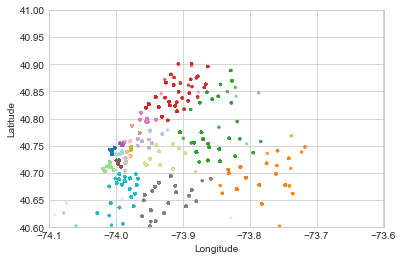

In [91]:
Clusters_Plot(frame_with_outliers_removed)

# Binning

In [100]:
unix_pickup_times=[i for i in frame_with_outliers_removed['pickup_times'].values]
unix_pickup_times[:5]


[1543642102.0, 1543643549.0, 1543642508.0, 1543641714.0, 1543640438.0]

In [101]:
unix_pickup_times[7877053:7877058]

[1546317645.0, 1546317918.0, 1546316206.0, 1546316941.0, 1546318539.0]

In [163]:
def pickup_10min_bins(frame,month,year):
    unix_pickup_times=[i for i in frame['pickup_times'].values]
    unix_times = [1543642102,1543643549, 1543642508,1543641714,1543640438,1546317645,1546317918,1546316206,1546316941,1546318539,1546300801,1548979201,1551398401]
    start_pickup_unix=unix_times[year-2018]#[month-12]]
    tenminutewise_binned_unix_pickup_times=[(int((i-start_pickup_unix)/600)+33) for i in unix_pickup_times]
    frame['pickup_bins'] = np.array(tenminutewise_binned_unix_pickup_times)
    return frame

In [164]:
frame_with_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_outliers_removed[['Pickup_Cordinates_lattitude', 'Pickup_Cordinates_logitude']])
dec_2018_frame = pickup_10min_bins(frame_with_outliers_removed,12,2018)
dec_2018_groupby = dec_2018_frame[['pickup_cluster','pickup_bins','trip_distance']].groupby(['pickup_cluster','pickup_bins']).count()

In [157]:
dec_2018_frame.head()

,passenger_count,trip_distance,Pickup_Cordinates_logitude,Pickup_Cordinates_lattitude,Dropoff_Cordinates_logitude,Dropoff_Cordinates_lattitude,total_amount,trip_times,pickup_times,Speed,pickup_cluster,pickup_bins
0,2,2.5,-73.985673,40.717802,-73.990163,40.735909,17.25,15.750000,1.543642e+09,9.523810,15,33
1,3,2.3,-73.976774,40.747629,-73.994829,40.722888,17.15,19.133333,1.543644e+09,7.212544,16,35
3,1,3.9,-73.843931,40.721512,-73.830253,40.763641,16.55,8.050000,1.543643e+09,29.068323,4,33
4,1,12.8,-73.986950,40.756061,-74.007532,40.644337,55.55,53.316667,1.543642e+09,14.404501,8,33
5,1,18.8,-73.782034,40.643575,-73.978620,40.689810,62.15,28.800000,1.543640e+09,39.166667,2,31


In [158]:
dec_2018_groupby.head()

trip_distance
pickup_cluster pickup_bins               
0              -521462                  1
               -521393                  1
               -521389                  1
               -521380                  2
               -521373                  1

In [159]:
dec_2018_groupby.tail()

trip_distance
pickup_cluster pickup_bins               
19             12302                    1
               30222                    1
               30224                    1
               30233                    1
               106712                   1

In [149]:
from sklearn.cluster import MiniBatchKMeans, KMeans

In [150]:
import gpxpy.geo 

from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

In [151]:
import datetime #Convert to unix time

import time

# Data Preparation

In [396]:
# Data Preparation for the months of January ,February and March 2019

def data_preparation(month,kmeans,month_no,year_no):
    
    print ("Return including trip times..")

    frame_with_durations = trip_time_return(month)
    
    print ("Remove outliers..")
    frame_with_outliers_removed = removing_outliers(frame_with_durations)
    
    print ("Estimate clusters..")
    frame_with_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_outliers_removed[["Pickup_Cordinates_lattitude",'Pickup_Cordinates_logitude']])
 

    print ("Group by..")
    final_updated_dataframe = pickup_10min_bins(frame_with_outliers_removed,month_no,year_no)
    final_groupby_dataframe = final_updated_dataframe[['pickup_cluster','pickup_bins','trip_distance']].groupby(['pickup_cluster','pickup_bins']).count()
    
    return final_updated_dataframe,final_groupby_dataframe
    
month_january_2019 = dd.read_csv('YelloCab_2019_Jan.csv')
month_febraury_2019 = dd.read_csv('YelloCab_2019_Feb.csv')
month_march_2019 = dd.read_csv('YellowCab_2019_Mar.csv')

january_2019_frame,january_2019_groupby = data_preparation(month_january_2019,kmeans,1,2019)
febraury_2019_frame,febraury_2019_groupby = data_preparation(month_febraury_2019,kmeans,2,2019)
march_2019_frame,march_2019_groupby = data_preparation(month_march_2019,kmeans,3,2019)

Return including trip times..
Remove outliers..
Number of pickup records =  7480391
No.of outlier coordinates lying outside NY boundaries: 16256
No.of outliers from trip times: 19851
No.of outliers from trip distance: 46533
No.of outliers from speed: 5824
No.of outliers from fare: 7714
Total outliers removed 91980
---
Estimate clusters..
Group by..
Return including trip times..
Remove outliers..
Number of pickup records =  6922978
No.of outlier coordinates lying outside NY boundaries: 17118
No.of outliers from trip times: 17761
No.of outliers from trip distance: 42760
No.of outliers from speed: 5268
No.of outliers from fare: 10089
Total outliers removed 88816
---
Estimate clusters..
Group by..
Return including trip times..
Remove outliers..
Number of pickup records =  7745265
No.of outlier coordinates lying outside NY boundaries: 20862
No.of outliers from trip times: 19515
No.of outliers from trip distance: 44356
No.of outliers from speed: 5887
No.of outliers from fare: 12029
Total out

In [458]:
january_2019_groupby

trip_distance
pickup_cluster pickup_bins               
0              -521401                  1
               -521398                  1
               -521396                  1
               -521395                  1
               -521394                  1
...                                   ...
19              9151                    1
                12222                   1
                21439                   1
                30651                   1
                36796                   1

[88940 rows x 1 columns]

In [439]:
january_2019_frame.head()

,passenger_count,trip_distance,Pickup_Cordinates_logitude,Pickup_Cordinates_lattitude,Dropoff_Cordinates_logitude,Dropoff_Cordinates_lattitude,total_amount,trip_times,pickup_times,Speed,pickup_cluster,pickup_bins
0,1,1.5,-73.963854,40.797924,-73.975416,40.787046,9.95,6.666667,1.546322e+09,13.500000,12,4496
1,1,2.6,-73.975416,40.787046,-74.001528,40.746491,16.30,19.200000,1.546322e+09,8.125000,7,4497
7,1,3.7,-73.960182,40.758037,-73.930137,40.772046,18.50,13.633333,1.546321e+09,16.283619,9,4494
8,2,2.1,-73.935895,40.820910,-73.990163,40.735909,13.00,12.000000,1.546322e+09,10.500000,6,4497
9,1,1.3,-73.986950,40.756061,-73.960182,40.758037,9.05,7.150000,1.546320e+09,10.909091,8,4493


In [440]:
febraury_2019_frame.head()

,passenger_count,trip_distance,Pickup_Cordinates_logitude,Pickup_Cordinates_lattitude,Dropoff_Cordinates_logitude,Dropoff_Cordinates_lattitude,total_amount,trip_times,pickup_times,Speed,pickup_cluster,pickup_bins
0,1,2.1,-73.984468,40.720257,-73.990163,40.735909,12.3,8.383333,1.549001e+09,15.029821,15,8961
1,1,9.8,-73.985855,40.757281,-73.845465,40.744158,33.3,30.816667,1.548999e+09,19.080584,13,8959
3,1,0.8,-73.843931,40.721512,-73.843931,40.721512,6.8,5.533333,1.549000e+09,8.674699,4,8960
4,1,0.8,-73.935895,40.820910,-73.948202,40.778007,6.3,2.733333,1.548999e+09,17.560976,6,8958
5,1,0.8,-73.960182,40.758037,-73.935895,40.820910,5.8,2.916667,1.548999e+09,16.457143,9,8959


In [168]:
march_2019_frame.head()

,passenger_count,trip_distance,Pickup_Cordinates_logitude,Pickup_Cordinates_lattitude,Dropoff_Cordinates_logitude,Dropoff_Cordinates_lattitude,total_amount,trip_times,pickup_times,Speed,pickup_cluster,pickup_bins
1,2,3.7,-73.843931,40.721512,-73.805689,40.691492,15.00,11.166667,1.551418e+09,19.880597,4,12990
2,1,14.1,-74.005580,40.734186,-73.813590,40.710924,60.66,33.033333,1.551417e+09,25.610494,0,12988
3,1,9.6,-73.871856,40.774529,-73.773559,40.736086,28.30,17.133333,1.551419e+09,33.618677,4,12992
4,1,0.8,-73.984468,40.720257,-73.984468,40.720257,12.30,4.966667,1.551417e+09,9.664430,15,12988
5,1,1.2,-74.001528,40.746491,-73.984468,40.720257,9.80,4.583333,1.551419e+09,15.709091,0,12992


In [169]:
january_2019_groupby.head()

trip_distance
pickup_cluster pickup_bins               
0              -521401                  1
               -521398                  1
               -521396                  1
               -521395                  1
               -521394                  1

In [170]:
febraury_2019_groupby.head()

trip_distance
pickup_cluster pickup_bins               
0              -521402                  1
               -521401                  1
               -521393                  2
               -521392                  1
               -521388                  1

In [171]:
march_2019_groupby.head()

trip_distance
pickup_cluster pickup_bins               
0              -521393                  1
                12943                   1
                12959                   1
                12960                   4
                12962                   1

# smoothing

In [397]:
def ret_unique_pickup_bins(dataframe):
    values = []
    for i in range(0,20):
        new = dataframe[dataframe['pickup_cluster'] == i]
        list_unq = list(set(new['pickup_bins']))
        list_unq.sort()
        values.append(list_unq)
    return values

In [446]:
december_2018_unique = ret_unique_pickup_bins(dec_2018_frame)
january_2016_unique = ret_unique_pickup_bins(january_2019_frame)

#feb
febraury_2016_unique = ret_unique_pickup_bins(febraury_2019_frame)

#march
march_2016_unique = ret_unique_pickup_bins(march_2019_frame)

In [447]:
for i in range(20):
    print("for the ",i,"th cluster number of 10min intavels with zero pickups: ",4464 - len(set(december_2018_unique[i])))
    print('-'*60)

for the  0 th cluster number of 10min intavels with zero pickups:  -36
------------------------------------------------------------
for the  1 th cluster number of 10min intavels with zero pickups:  -21
------------------------------------------------------------
for the  2 th cluster number of 10min intavels with zero pickups:  -21
------------------------------------------------------------
for the  3 th cluster number of 10min intavels with zero pickups:  -9
------------------------------------------------------------
for the  4 th cluster number of 10min intavels with zero pickups:  12
------------------------------------------------------------
for the  5 th cluster number of 10min intavels with zero pickups:  -17
------------------------------------------------------------
for the  6 th cluster number of 10min intavels with zero pickups:  -29
------------------------------------------------------------
for the  7 th cluster number of 10min intavels with zero pickups:  -20
-------

Fills a value of zero for every bin where no pickup data is present 
the count_values: number pickps that are happened in each region for each 10min intravel
there wont be any value if there are no picksups.
Values: number of unique bins

for every 10min intravel(pickup_bin) we will check it is there in our unique bin,
if it is there we will add the count_values[index] to smoothed data
if not we add 0 to the smoothed data
we finally return smoothed data

In [402]:
#filling missing values with zero

def fill_Missing_With_Zero(count_values,values):
    smoothed_regions=[]
    ind=0
    for r in range(0,20):
        smoothed_bins=[]
        for i in range(4464):
            if i in values[r]:
                smoothed_bins.append(count_values[ind])
                ind+=1
            else:
                smoothed_bins.append(0)
        smoothed_regions.extend(smoothed_bins)
    return smoothed_regions

In [403]:
def smoothing(count_values,values):
    smoothed_regions=[] 
    ind=0
    repeat=0 
    smoothed_value=0
    for r in range(0,20):
        smoothed_bins=[] 
        repeat=0
        for i in range(4464):
            if repeat!=0: 
                repeat-=1
                continue
            if i in values[r]:
                smoothed_bins.append(count_values[ind]) 
            else:
                if i!=0:
                    right_hand_limit=0
                    for j in range(i,4464):
                        if  j not in values[r]: 
                            continue
                        else:
                            right_hand_limit=j
                            break
                    if right_hand_limit==0:
                        smoothed_value=count_values[ind-1]*1.0/((4463-i)+2)*1.0                               
                        for j in range(i,4464):                              
                            smoothed_bins.append(math.ceil(smoothed_value))
                        smoothed_bins[i-1] = math.ceil(smoothed_value)
                        repeat=(4463-i)
                        ind-=1
                    else:
                        smoothed_value=(count_values[ind-1]+count_values[ind])*1.0/((right_hand_limit-i)+2)*1.0             
                        for j in range(i,right_hand_limit+1):
                            smoothed_bins.append(math.ceil(smoothed_value))
                        smoothed_bins[i-1] = math.ceil(smoothed_value)
                        repeat=(right_hand_limit-i)
                else:
                    right_hand_limit=0
                    for j in range(i,4464):
                        if  j not in values[r]:
                            continue
                        else:
                            right_hand_limit=j
                            break
                    smoothed_value=count_values[ind]*1.0/((right_hand_limit-i)+1)*1.0
                    for j in range(i,right_hand_limit+1):
                            smoothed_bins.append(math.ceil(smoothed_value))
                    repeat=(right_hand_limit-i)
            ind+=1
        smoothed_regions.extend(smoothed_bins)
    return smoothed_regions

In [448]:
dec_2018_fillZero = fill_Missing_With_Zero(dec_2018_groupby ["trip_distance"].values, december_2018_unique)
dec_2018_fillSmooth = smoothing(dec_2018_groupby["trip_distance"].values, december_2018_unique)



we have taken total 30 clusters. Each cluster has 4464 time bins. 
After smoothing or fillWithZero, each of 4464 time bin has a pickup. 
So, there should be a total of 4464*20 = 89289 pickup values present for the month of december 2019. Let's Check

In [449]:
print("number of 10min intravels  ",len(dec_2018_fillZero))

number of 10min intravels   89280


In [450]:

def countZeros(num):
    count = 0
    for i in num:
        if i == 0:
            count += 1
    return count

In [451]:
print("No.of values filled with zero in zero fill data= "+str(countZeros(dec_2018_fillZero)))

No.of values filled with zero in zero fill data= 934


In [452]:
print("Sanity check for number of zeros in smoothed data = "+str(countZeros(dec_2018_fillSmooth)))

Sanity check for number of zeros in smoothed data = 0


In [453]:
print("Total number of pickup values = "+str(len(dec_2018_fillZero)))
print("Total number of pickup values = "+str(len(dec_2018_fillSmooth)))

Total number of pickup values = 89280
Total number of pickup values = 89280


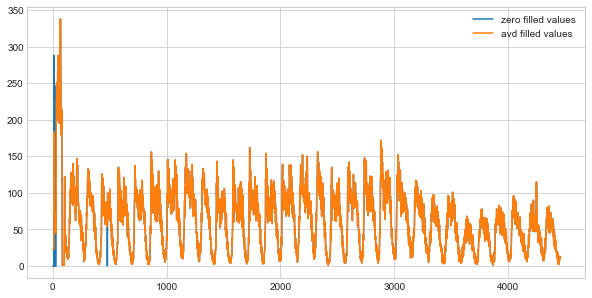

In [454]:
plt.figure(figsize=(10,5))
plt.plot(dec_2018_fillZero[4464:8920], label="zero filled values")
plt.plot(dec_2018_fillSmooth[4464:8920], label="avd filled values")
plt.legend()
plt.show()

In [473]:
test_grp = january_2019_groupby ['trip_distance']

In [474]:
test_grp

pickup_cluster  pickup_bins
0               -521401        1
                -521398        1
                -521396        1
                -521395        1
                -521394        1
                              ..
19               9151          1
                 12222         1
                 21439         1
                 30651         1
                 36796         1
Name: trip_distance, Length: 88940, dtype: int64

In [511]:
#dec_2018_fillZero = fill_Missing_With_Zero(dec_2018_groupby ["trip_distance"].values, december_2018_unique)

#dec_2018_fillSmooth = smoothing(dec_2018_groupby["trip_distance"].values, december_2018_unique)

jan_2019_fillZero = fill_Missing_With_Zero(test_grp,january_2019_unique)
jan_2019_fillSmooth = smoothing(january_2019_groupby["trip_distance"].values, january_2019_unique)

#feb_2019_fillZero = fill_Missing_With_Zero(febraury_2019_groupby['trip_distance'].values,february_2019_unique)
#feb_2019_fillSmooth = smoothing(febraury_2019_groupby["trip_distance"].values, february_2019_unique)


#mar_2019_fillZero = fill_Missing_With_Zero(march_2019_groupby['trip_distance'].values,march_2019_unique)
#mar_2019_fillSmooth = smoothing(march_2019_groupby['trip_distance'].values,march_2019_unique)

regions_cum = []

for i in range(0,20):
    regions_cum.append(jan_2019_fillSmooth[4464*i:4464*(i+1)])

In [423]:
frame_with_outliers_removed_jan_2019['pickup_cluster'] = kmeans.predict(frame_with_outliers_removed_jan_2019[['Pickup_Cordinates_lattitude', 'Pickup_Cordinates_logitude']])

In [426]:
january_2019_frame = pickup_10min_bins(frame_with_outliers_removed_jan_2019,1,2019)
january_2019_groupby = january_2019_frame[['pickup_cluster','pickup_bins','trip_distance']].groupby(['pickup_cluster','pickup_bins']).count()

In [429]:
january_2019_frame

,passenger_count,trip_distance,Pickup_Cordinates_logitude,Pickup_Cordinates_lattitude,Dropoff_Cordinates_logitude,Dropoff_Cordinates_lattitude,total_amount,trip_times,pickup_times,Speed,pickup_cluster,pickup_bins
0,1,1.50,-73.963854,40.797924,-73.975416,40.787046,9.95,6.666667,1.546322e+09,13.500000,12,4496
1,1,2.60,-73.975416,40.787046,-74.001528,40.746491,16.30,19.200000,1.546322e+09,8.125000,7,4497
7,1,3.70,-73.960182,40.758037,-73.930137,40.772046,18.50,13.633333,1.546321e+09,16.283619,9,4494
8,2,2.10,-73.935895,40.820910,-73.990163,40.735909,13.00,12.000000,1.546322e+09,10.500000,6,4497
9,1,1.30,-73.986950,40.756061,-73.960182,40.758037,9.05,7.150000,1.546320e+09,10.909091,8,4493
...,...,...,...,...,...,...,...,...,...,...,...,...
156907,2,4.28,-73.990699,40.751037,-73.948202,40.778007,21.96,18.700000,1.548996e+09,13.732620,8,8952
156908,1,4.79,-73.948202,40.778007,-73.985282,40.727587,23.16,21.050000,1.548997e+09,13.653207,1,8955
156911,4,2.60,-74.006704,40.710394,-73.990947,40.739668,12.30,12.200000,1.548994e+09,12.786885,5,8951
156912,1,7.50,-73.993145,40.754312,-73.986123,40.685029,26.80,25.866667,1.548997e+09,17.396907,8,8954


In [427]:
january_2019_unique = ret_unique_pickup_bins(january_2019_frame)
for i in range(20):             
    print("For cluster ID {}, total number of time bins with no pickup cluster {}".format(i, (4464 - len(january_2019_unique[i]))))
    print("-"*90)

For cluster ID 0, total number of time bins with no pickup cluster -27
------------------------------------------------------------------------------------------
For cluster ID 1, total number of time bins with no pickup cluster -6
------------------------------------------------------------------------------------------
For cluster ID 2, total number of time bins with no pickup cluster 31
------------------------------------------------------------------------------------------
For cluster ID 3, total number of time bins with no pickup cluster 3
------------------------------------------------------------------------------------------
For cluster ID 4, total number of time bins with no pickup cluster 50
------------------------------------------------------------------------------------------
For cluster ID 5, total number of time bins with no pickup cluster -8
------------------------------------------------------------------------------------------
For cluster ID 6, total number of 

In [430]:
january_2019_fillZero = fill_Missing_With_Zero(january_2019_groupby ["trip_distance"].values, january_2019_unique)

january_2019_fillSmooth = smoothing(january_2019_groupby ["trip_distance"].values, january_2019_unique)

# Time series and Fourier Transforms

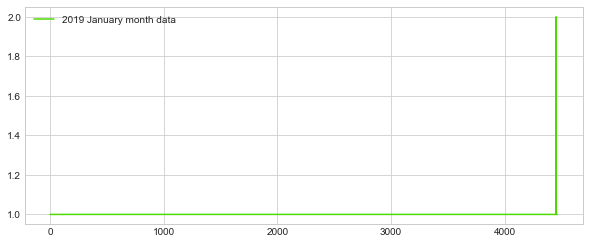

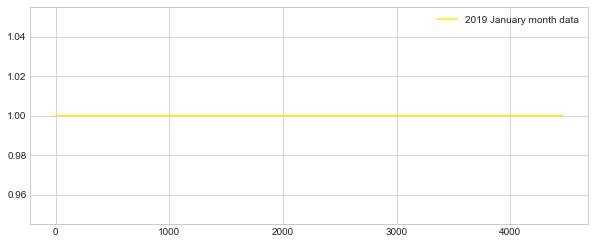

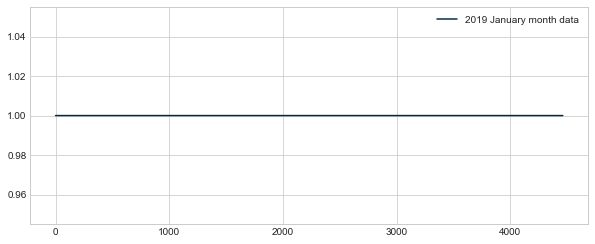

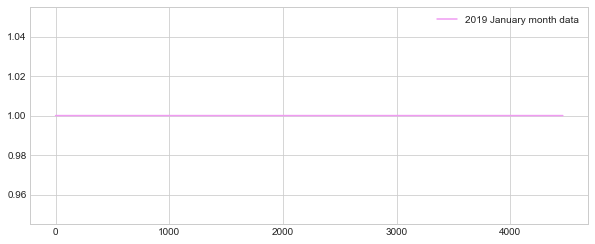

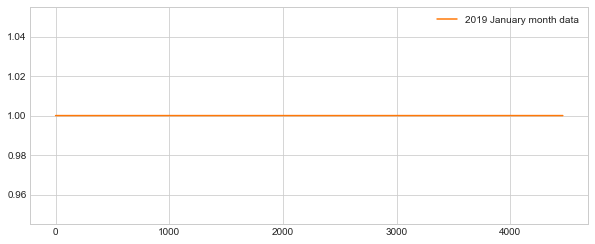

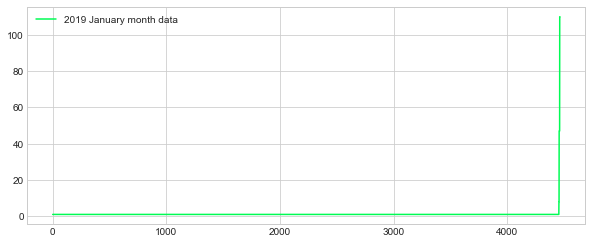

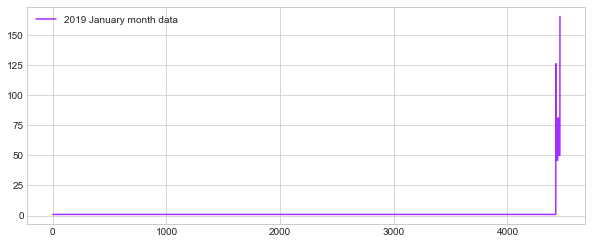

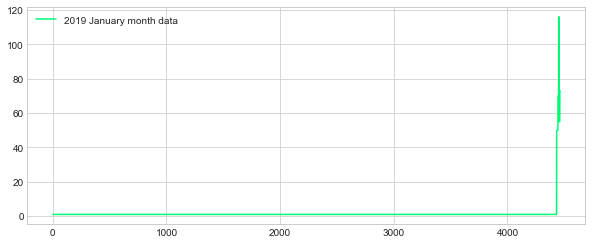

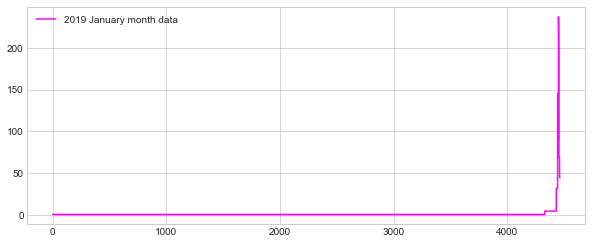

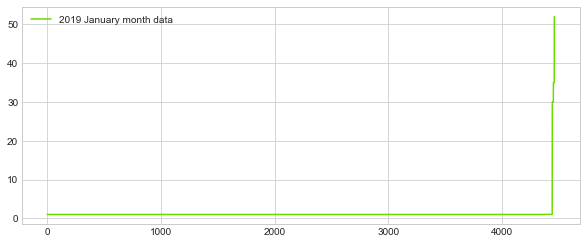

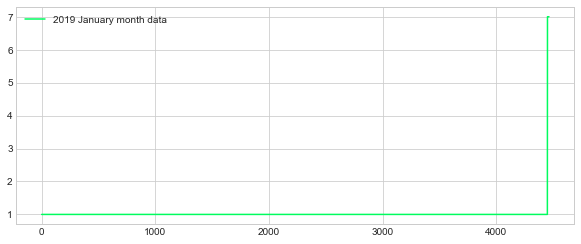

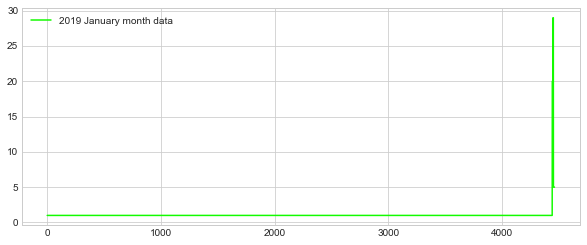

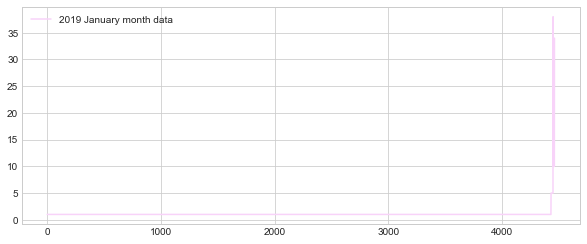

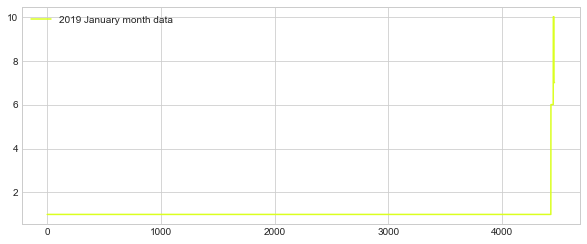

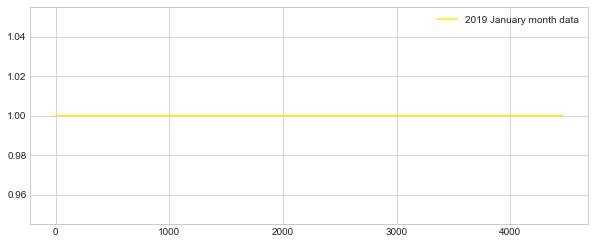

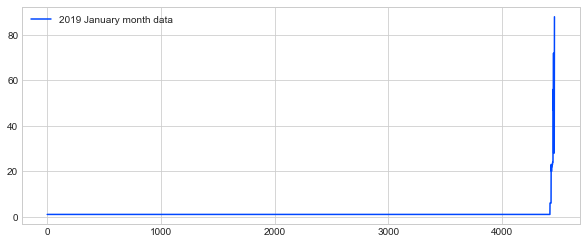

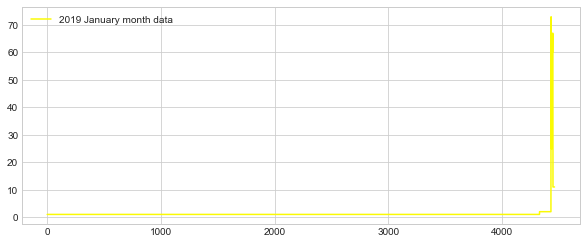

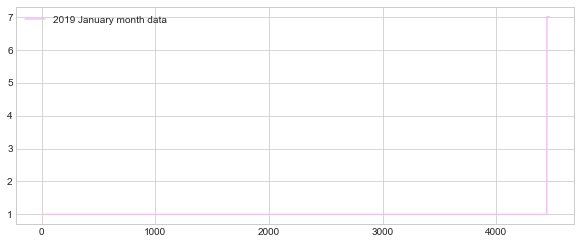

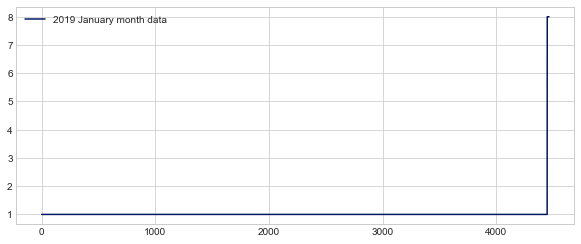

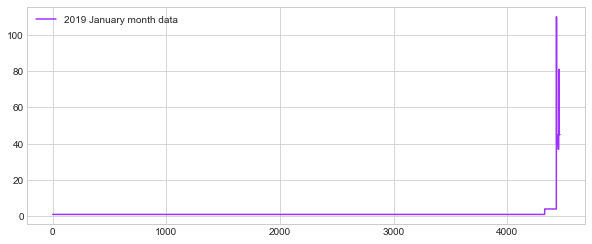

In [512]:
def uniq_color():
    
    return plt.cm.gist_ncar(np.random.random())
first_x = list(range(0,4464))
for i in range(20):
    plt.figure(figsize=(10,4))
    plt.plot(first_x,regions_cum[i][:4464], color=uniq_color(), label='2019 January month data')
    plt.legend()
    plt.show()

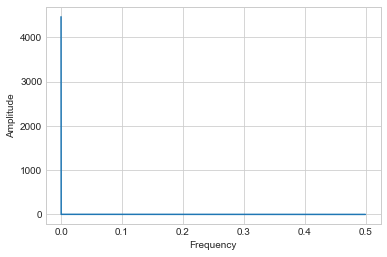

In [386]:
Y    = np.fft.fft(np.array(jan_2019_fillSmooth)[0:4464])

freq = np.fft.fftfreq(4464, 1)
n = len(freq)
plt.figure()
plt.plot( freq[:int(n/2)], np.abs(Y)[:int(n/2)] )
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.show()

In [307]:
#jan_2019_fillSmooth = smoothing(january_2019_groupby['trip_distance'].values,january_2019_unique)

#Preparing the Dataframe only with x(i) values as dec-2018 data and y(i) values as jan-2019

In [513]:
ratios_january = pd.DataFrame()
ratios_january["Given"] = dec_2018_fillSmooth
ratios_january["Prediction"] = jan_2019_fillSmooth
ratios_january["Ratios"] = ratios_january["Prediction"]*1.0/ratios_january["Given"]*1.0

In [514]:
ratios_january.tail(10)

,Given,Prediction,Ratios
89270,133,81,0.609023
89271,114,81,0.710526
89272,105,45,0.428571
89273,104,45,0.432692
89274,102,45,0.441176
89275,107,45,0.420561
89276,118,45,0.381356
89277,113,45,0.398230
89278,116,45,0.387931
89279,109,45,0.412844


In [515]:
ratios_january.shape

(89280, 3)

# Base Model with Moving Average

## Modelling: Baseline Models

Now we get into modelling in order to forecast the pickup densities for the months of Jan, Feb and March of 2019 for which we are using multiple models with two variations 
1. Using Ratios of the 2019 data to the 2018 data i.e $\begin{align} R_{t} = P^{2019}_{t} / P^{2018}_{t} \end{align}$
2. Using Previous known values of the 2016 data itself to predict the future values

### Simple Moving Averages
The First Model used is the Moving Averages Model which uses the previous n values in order to predict the next value <br> 

Using Ratio Values - $\begin{align}R_{t} = ( R_{t-1} + R_{t-2} + R_{t-3} .... R_{t-n} )/n \end{align}$

In [516]:
def MovAvg_R_Predictions(ratios,month):
    predicted_ratio=(ratios['Ratios'].values)[0]
    error=[]
    predicted_values=[]
    window_size=3
    predicted_ratio_values=[]
    for i in range(0,4464*20):
        if i%4464==0:
            predicted_ratio_values.append(0)
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_ratio_values.append(predicted_ratio)
        predicted_values.append(int(((ratios['Given'].values)[i])*predicted_ratio))
        error.append(abs((math.pow(int(((ratios['Given'].values)[i])*predicted_ratio)-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            predicted_ratio=sum((ratios['Ratios'].values)[(i+1)-window_size:(i+1)])/window_size
        else:
            predicted_ratio=sum((ratios['Ratios'].values)[0:(i+1)])/(i+1)
            
    
    ratios['MA_R_Predicted'] = predicted_values
    ratios['MA_R_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

Next we use the Moving averages of the 2019  values itself to predict the future value using $\begin{align}P_{t} = ( P_{t-1} + P_{t-2} + P_{t-3} .... P_{t-n} )/n \end{align}$

In [517]:
def MovAvg_P_Predictions(ratios,month):
    predicted_value=(ratios['Prediction'].values)[0]
    error=[]
    predicted_values=[]
    window_size=1
    predicted_ratio_values=[]
    for i in range(0,4464*20):
        predicted_values.append(predicted_value)
        error.append(abs((math.pow(predicted_value-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            predicted_value=int(sum((ratios['Prediction'].values)[(i+1)-window_size:(i+1)])/window_size)
        else:
            predicted_value=int(sum((ratios['Prediction'].values)[0:(i+1)])/(i+1))
            
    ratios['MA_P_Predicted'] = predicted_values
    ratios['MA_P_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

# Weighted Moving Average

Weighted Moving Averages using Ratio Values - $\begin{align}R_{t} = ( N*R_{t-1} + (N-1)*R_{t-2} + (N-2)*R_{t-3} .... 1*R_{t-n} )/(N*(N+1)/2) \end{align}$

In [518]:
def WeighMovAvg_R_Predictions(ratios,month):
    predicted_ratio=(ratios['Ratios'].values)[0]
    alpha=0.5
    error=[]
    predicted_values=[]
    window_size=5
    predicted_ratio_values=[]
    for i in range(0,4464*20):
        if i%4464==0:
            predicted_ratio_values.append(0)
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_ratio_values.append(predicted_ratio)
        predicted_values.append(int(((ratios['Given'].values)[i])*predicted_ratio))
        error.append(abs((math.pow(int(((ratios['Given'].values)[i])*predicted_ratio)-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            sum_values=0
            sum_of_coeff=0
            for j in range(window_size,0,-1):
                sum_values += j*(ratios['Ratios'].values)[i-window_size+j]
                sum_of_coeff+=j
            predicted_ratio=sum_values/sum_of_coeff
        else:
            sum_values=0
            sum_of_coeff=0
            for j in range(i+1,0,-1):
                sum_values += j*(ratios['Ratios'].values)[j-1]
                sum_of_coeff+=j
            predicted_ratio=sum_values/sum_of_coeff
            
    ratios['WA_R_Predicted'] = predicted_values
    ratios['WA_R_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

Weighted Moving Averages using Previous 2019 Values - $\begin{align}P_{t} = ( N*P_{t-1} + (N-1)*P_{t-2} + (N-2)*P_{t-3} .... 1*P_{t-n} )/(N*(N+1)/2) \end{align}$

In [519]:
def WeighMovAvg_P_Predictions(ratios,month):
    predicted_value=(ratios['Prediction'].values)[0]
    error=[]
    predicted_values=[]
    window_size=2
    for i in range(0,4464*20):
        predicted_values.append(predicted_value)
        error.append(abs((math.pow(predicted_value-(ratios['Prediction'].values)[i],1))))
        if i+1>=window_size:
            sum_values=0
            sum_of_coeff=0
            for j in range(window_size,0,-1):
                sum_values += j*(ratios['Prediction'].values)[i-window_size+j]
                sum_of_coeff+=j
            predicted_value=int(sum_values/sum_of_coeff)

        else:
            sum_values=0
            sum_of_coeff=0
            for j in range(i+1,0,-1):
                sum_values += j*(ratios['Prediction'].values)[j-1]
                sum_of_coeff+=j
            predicted_value=int(sum_values/sum_of_coeff)
    
    ratios['WA_P_Predicted'] = predicted_values
    ratios['WA_P_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err
##For the above the Hyperparameter is the window-size (n) which is tuned manually 
##and it is found that the window-size of 2 is optimal for getting the best results
##using Weighted Moving Averages using previous 2019 values therefore we get $\begin{align}
##P_{t} = ( 2*P_{t-1} + P_{t-2} )/3 \end{align}$

# Exponential Moving Average

$\begin{align}R^{'}_{t} = \alpha*R_{t-1} + (1-\alpha)*R^{'}_{t-1}  \end{align}$

In [520]:
def ExpMovAvg_R1_Predictions(ratios,month):
    predicted_ratio=(ratios['Ratios'].values)[0]
    alpha=0.6
    error=[]
    predicted_values=[]
    predicted_ratio_values=[]
    for i in range(0,4464*20):
        if i%4464==0:
            predicted_ratio_values.append(0)
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_ratio_values.append(predicted_ratio)
        predicted_values.append(int(((ratios['Given'].values)[i])*predicted_ratio))
        error.append(abs((math.pow(int(((ratios['Given'].values)[i])*predicted_ratio)-(ratios['Prediction'].values)[i],1))))
        predicted_ratio = (alpha*predicted_ratio) + (1-alpha)*((ratios['Ratios'].values)[i])
    
    ratios['EA_R1_Predicted'] = predicted_values
    ratios['EA_R1_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

Exponential Moving Averages using Previous 2019 Values- $\begin{align}P^{'}_{t} = \alpha*P_{t-1} + (1-\alpha)*P^{'}_{t-1}  \end{align}$

In [521]:
def  ExpMovAvg_P1_Predictions(ratios,month):
    predicted_value= (ratios['Prediction'].values)[0]
    alpha=0.3
    error=[]
    predicted_values=[]
    for i in range(0,4464*20):
        if i%4464==0:
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_values.append(predicted_value)
        error.append(abs((math.pow(predicted_value-(ratios['Prediction'].values)[i],1))))
        predicted_value =int((alpha*predicted_value) + (1-alpha)*((ratios['Prediction'].values)[i]))
    
    ratios['EA_P1_Predicted'] = predicted_values
    ratios['EA_P1_Error'] = error
    mape_err = (sum(error)/len(error))/(sum(ratios['Prediction'].values)/len(ratios['Prediction'].values))
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios,mape_err,mse_err

In [522]:
r1, mape1, mse1 = MovAvg_R_Predictions(ratios_january,'Jan')
r2, mape2, mse2 = MovAvg_P_Predictions(ratios_january,'Jan')
r3, mape3, mse3 = WeighMovAvg_R_Predictions(ratios_january,'Jan')
r4, mape4, mse4 = WeighMovAvg_P_Predictions(ratios_january,'Jan')
r5, mape5, mse5 = ExpMovAvg_R1_Predictions(ratios_january,'Jan')
r6, mape6, mse6 = ExpMovAvg_P1_Predictions(ratios_january,'Jan')

In [523]:

error_table_baseline = pd.DataFrame(columns = ["Model", "MAPE(%)", "MSE"])
error_table_baseline = error_table_baseline.append(pd.DataFrame([["Simple Moving Average Ratios", mape1*100, mse1]], columns = ["Model", "MAPE(%)", "MSE"]))
error_table_baseline = error_table_baseline.append(pd.DataFrame([["Simple Moving Average Predictions", mape2*100, mse2]], columns = ["Model", "MAPE(%)", "MSE"]))
error_table_baseline = error_table_baseline.append(pd.DataFrame([["Weighted Moving Average Ratios", mape3*100, mse3]], columns = ["Model", "MAPE(%)", "MSE"]))
error_table_baseline = error_table_baseline.append(pd.DataFrame([["Weighted Moving Average Predictions", mape4*100, mse4]], columns = ["Model", "MAPE(%)", "MSE"]))
error_table_baseline = error_table_baseline.append(pd.DataFrame([["Exponential Weighted Moving Average Ratios", mape5*100, mse5]], columns = ["Model", "MAPE(%)", "MSE"]))
error_table_baseline = error_table_baseline.append(pd.DataFrame([["Exponential Weighted Moving Average Predictions", mape6*100, mse6]], columns = ["Model", "MAPE(%)", "MSE"]))

error_table_baseline.reset_index(drop = True, inplace = True)

In [524]:
error_table_baseline.style.highlight_min(axis=0)

,Model,MAPE(%),MSE
0,Simple Moving Average Ratios,51.9342,4.83703
1,Simple Moving Average Predictions,2.67999,2.33087
2,Weighted Moving Average Ratios,52.6387,5.72696
3,Weighted Moving Average Predictions,3.48165,2.56762
4,Exponential Weighted Moving Average Ratios,52.7747,5.43487
5,Exponential Weighted Moving Average Predictions,3.93447,2.43648


In [525]:
mean_err=[0]*10
median_err=[0]*10
ratios_january,mean_err[0],median_err[0]=MovAvg_R_Predictions(ratios_january,'Jan')
ratios_january,mean_err[1],median_err[1]=MovAvg_P_Predictions(ratios_january,'Jan')
ratios_january,mean_err[2],median_err[2]=WeighMovAvg_R_Predictions(ratios_january,'Jan')
ratios_january,mean_err[3],median_err[3]=WeighMovAvg_P_Predictions(ratios_january,'Jan')
ratios_january,mean_err[4],median_err[4]=ExpMovAvg_R1_Predictions(ratios_january,'Jan')
ratios_january,mean_err[5],median_err[5]=ExpMovAvg_P1_Predictions(ratios_january,'Jan')

# Comparing baseline models

In [526]:
print ("Error Metric Matrix (Forecasting Methods) - MAPE & MSE")
print ("--------------------------------------------------------------------------------------------------------")
print ("Moving Averages (Ratios) -                             MAPE: ",mean_err[0],"      MSE: ",median_err[0])
print ("Moving Averages (2019 Values) -                        MAPE: ",mean_err[1],"       MSE: ",median_err[1])
print ("--------------------------------------------------------------------------------------------------------")
print ("Weighted Moving Averages (Ratios) -                    MAPE: ",mean_err[2],"      MSE: ",median_err[2])
print ("Weighted Moving Averages (2019 Values) -               MAPE: ",mean_err[3],"      MSE: ",median_err[3])
print ("--------------------------------------------------------------------------------------------------------")
print ("Exponential Moving Averages (Ratios) -              MAPE: ",mean_err[4],"      MSE: ",median_err[4])
print ("Exponential Moving Averages (2019 Values) -         MAPE: ",mean_err[5],"      MSE: ",median_err[5])

Error Metric Matrix (Forecasting Methods) - MAPE & MSE
--------------------------------------------------------------------------------------------------------
Moving Averages (Ratios) -                             MAPE:  0.5193419556704337       MSE:  4.837029569892473
Moving Averages (2019 Values) -                        MAPE:  0.026799856186413503        MSE:  2.33086917562724
--------------------------------------------------------------------------------------------------------
Weighted Moving Averages (Ratios) -                    MAPE:  0.5263868779819456       MSE:  5.726960125448029
Weighted Moving Averages (2019 Values) -               MAPE:  0.0348164919202029       MSE:  2.5676187275985662
--------------------------------------------------------------------------------------------------------
Exponential Moving Averages (Ratios) -              MAPE:  0.527747276773134       MSE:  5.434867831541219
Exponential Moving Averages (2019 Values) -         MAPE:  0.039344676468016

From the above error table it is inferred that the best forecasting model for our prediction would be Simple Moving Averages Predictions using 2019 Values.

# Regression Model

### Train-Test Split
Before we start predictions using the tree based regression models we take 3 months of 2019 pickup data and split it such that for every region we have 80% data in train and 20% in test, ordered date-wise for every region

In [531]:
number_of_time_stamps = 5
output = []
latt = []
long = []
weekday = []
feature = []


feature = [0]*number_of_time_stamps
for i in range(0,20):
    latt.append([kmeans.cluster_centers_[i][0]]*4459)
    long.append([kmeans.cluster_centers_[i][1]]*4459)
    weekday.append([int(((int(k/144))%7+4)%7) for k in range(5,4464)])
    feature = np.vstack((feature, [regions_cum[i][r:r+number_of_time_stamps] for r in range(0,len(regions_cum[i])-number_of_time_stamps)]))
    output.append(regions_cum[i][5:])
feature = feature[1:]

In [505]:
latt

[[40.74084788592855,
  40.74084788592855,
  40.74084788592855,
  40.74084788592855,
  40.74084788592855,
  40.74084788592855,
  40.74084788592855,
  40.74084788592855,
  40.74084788592855,
  40.74084788592855,
  40.74084788592855,
  40.74084788592855,
  40.74084788592855,
  40.74084788592855,
  40.74084788592855,
  40.74084788592855,
  40.74084788592855,
  40.74084788592855,
  40.74084788592855,
  40.74084788592855,
  40.74084788592855,
  40.74084788592855,
  40.74084788592855,
  40.74084788592855,
  40.74084788592855,
  40.74084788592855,
  40.74084788592855,
  40.74084788592855,
  40.74084788592855,
  40.74084788592855,
  40.74084788592855,
  40.74084788592855,
  40.74084788592855,
  40.74084788592855,
  40.74084788592855,
  40.74084788592855,
  40.74084788592855,
  40.74084788592855,
  40.74084788592855,
  40.74084788592855,
  40.74084788592855,
  40.74084788592855,
  40.74084788592855,
  40.74084788592855,
  40.74084788592855,
  40.74084788592855,
  40.74084788592855,
  40.74084788

In [500]:
long

[[-74.00618569121802,
  -74.00618569121802,
  -74.00618569121802,
  -74.00618569121802,
  -74.00618569121802,
  -74.00618569121802,
  -74.00618569121802,
  -74.00618569121802,
  -74.00618569121802,
  -74.00618569121802,
  -74.00618569121802,
  -74.00618569121802,
  -74.00618569121802,
  -74.00618569121802,
  -74.00618569121802,
  -74.00618569121802,
  -74.00618569121802,
  -74.00618569121802,
  -74.00618569121802,
  -74.00618569121802,
  -74.00618569121802,
  -74.00618569121802,
  -74.00618569121802,
  -74.00618569121802,
  -74.00618569121802,
  -74.00618569121802,
  -74.00618569121802,
  -74.00618569121802,
  -74.00618569121802,
  -74.00618569121802,
  -74.00618569121802,
  -74.00618569121802,
  -74.00618569121802,
  -74.00618569121802,
  -74.00618569121802,
  -74.00618569121802,
  -74.00618569121802,
  -74.00618569121802,
  -74.00618569121802,
  -74.00618569121802,
  -74.00618569121802,
  -74.00618569121802,
  -74.00618569121802,
  -74.00618569121802,
  -74.00618569121802,
  -74.0061

In [532]:
len(latt[0])*len(latt) == feature.shape[0] == len(weekday)*len(weekday[0]) == 20*4459 == len(output)*len(output[0])

True

In [534]:
alpha=0.3
predicted_values=[]
predict_list = []
tsne_flat_exp_avg = []
for r in range(0,20):
    for i in range(0,4464):
        if i==0:
            predicted_value= regions_cum[r][0]
            predicted_values.append(0)
            continue
        predicted_values.append(predicted_value)
        predicted_value =int((alpha*predicted_value) + (1-alpha)*(regions_cum[r][i]))
    predict_list.append(predicted_values[5:])
    predicted_values=[]

In [535]:
# train, test split : 80% 20%
print("size of train data :", int(4464*0.8))
print("size of test data :", int(4464*0.2))

size of train data : 3571
size of test data : 892


In [536]:
amplitude_lists = []
frequency_lists = []
for i in range(20):
    ampli  = np.abs(np.fft.fft(regions_cum[i][0:4096]))
    freq = np.abs(np.fft.fftfreq(4096, 1))
    ampli_indices = np.argsort(-ampli)[1:]        
    amplitude_values = []
    frequency_values = []
    for j in range(0, 9, 2): 
        amplitude_values.append(ampli[ampli_indices[j]])
        frequency_values.append(freq[ampli_indices[j]])
    for k in range(4459):    
        amplitude_lists.append(amplitude_values)
        frequency_lists.append(frequency_values)

In [537]:
print("size of total train data :" +str(int(133770*0.8)))
print("size of total test data :" +str(int(133770*0.2)))

size of total train data :107016
size of total test data :26754


In [543]:

predicted_pickup_values = []
predicted_pickup_values_list = []

predicted_value = -1  
window_size = 2
for i in range(20):
    for j in range(4464):
        if j == 0:
            predicted_value = regions_cum[i][j]
            predicted_pickup_values.append(0)
        else:
            if j>=window_size:
                sumPickups = 0
                sumOfWeights = 0
                for k in range(window_size, 0, -1):
                    sumPickups += k*(regions_cum[i][j -window_size + (k - 1)])
                    sumOfWeights += k
                predicted_value = int(sumPickups/sumOfWeights)
                predicted_pickup_values.append(predicted_value)
            else:
                sumPickups = 0
                sumOfWeights = 0
                for k in range(j, 0, -1):
                    sumPickups += k*regions_cum[i][k-1]
                    sumOfWeights += k
                predicted_value = int(sumPickups/sumOfWeights)
                predicted_pickup_values.append(predicted_value)
                
    predicted_pickup_values_list.append(predicted_pickup_values[5:])
    predicted_pickup_values = []

In [538]:
print("size of train data for one cluster:" +str(int(4459*0.8)))
print("size of total test data for one cluster:" +str(int(4459*0.2)))

size of train data for one cluster:3567
size of total test data for one cluster:891


In [539]:
train_previousFive_pickups  = [feature[i*4459:(4459*i+3567)] for i in range(20)]
test_previousFive_pickups  = [feature[(i*4459)+3567:(4459*(i+1))] for i in range(20)]

In [540]:
train_fourier_frequencies = [frequency_lists[i*4459:(4459*i+3567)] for i in range(20)]
test_fourier_frequencies = [frequency_lists[(i*4459)+3567:(4459*(i+1))] for i in range(20)]

In [541]:
train_fourier_amplitudes = [amplitude_lists[i*4459:(4459*i+3567)] for i in range(20)]
test_fourier_amplitudes = [amplitude_lists[(i*4459)+3567:(4459*(i+1))] for i in range(20)]

In [542]:
print("Train Data: Total number of clusters = {}. Number of points in each cluster = {}. Total number of training points = {}".format(len(train_previousFive_pickups), len(train_previousFive_pickups[0]), len(train_previousFive_pickups)*len(train_previousFive_pickups[0])))
print("Test Data: Total number of clusters = {}. Number of points in each cluster = {}. Total number of test points = {}".format(len(test_previousFive_pickups), len(test_previousFive_pickups[0]), len(test_previousFive_pickups)*len(test_previousFive_pickups[0])))

Train Data: Total number of clusters = 20. Number of points in each cluster = 3567. Total number of training points = 71340
Test Data: Total number of clusters = 20. Number of points in each cluster = 892. Total number of test points = 17840


In [544]:
train_lat = [i[:3567] for i in latt]
train_lon = [i[:3567] for i in long]
train_weekDay = [i[:3567] for i in weekday]
train_weighted_avg = [i[:3567] for i in predicted_pickup_values_list]
train_output = [i[:3567] for i in output]

In [545]:
test_lat = [i[3567:] for i in latt]
test_lon = [i[3567:] for i in long]
test_weekDay = [i[3567:] for i in weekday]
test_weighted_avg = [i[3567:] for i in predicted_pickup_values_list]
test_output = [i[3567:] for i in output]

In [546]:
train_pickups = []
test_pickups = []
train_freq = []
test_freq = []
train_amp = []
test_amp = []
for i in range(20):
    train_pickups.extend(train_previousFive_pickups[i])
    test_pickups.extend(test_previousFive_pickups[i])
    train_freq.extend(train_fourier_frequencies[i])
    test_freq.extend(test_fourier_frequencies[i])
    train_amp.extend(train_fourier_amplitudes[i])
    test_amp.extend(test_fourier_amplitudes[i])

In [549]:
train_prevPickups_freq_amp = np.hstack((train_pickups, train_freq, train_amp))
test_prevPickups_freq_amp = np.hstack((test_pickups, test_freq, test_amp))


In [550]:

print("Number of data points in train data = {}. Number of columns till now = {}".format(len(train_prevPickups_freq_amp), len(train_prevPickups_freq_amp[0])))
print("Number of data points in test data = {}. Number of columns till now = {}".format(len(test_prevPickups_freq_amp), len(test_prevPickups_freq_amp[0])))


Number of data points in train data = 71340. Number of columns till now = 15
Number of data points in test data = 17840. Number of columns till now = 15


In [552]:
train_list_lat = sum(train_lat, [])
train_list_lon = sum(train_lon, [])
train_list_weekDay = sum(train_weekDay, [])
train_weighted_avg_list = sum(train_weighted_avg, [])
train_output_list = sum(train_output, [])



In [553]:
test_list_lat = sum(test_lat, [])
test_list_lon = sum(test_lon, [])
test_list_weekDay = sum(test_weekDay, [])
test_weighted_avg_list = sum(test_weighted_avg, [])
test_output_list = sum(test_output, [])

In [554]:
columns = ['ft_5','ft_4','ft_3','ft_2','ft_1', 'freq1', 'freq2','freq3','freq4','freq5', 'Amp1', 'Amp2', 'Amp3', 'Amp4', 'Amp5']
Train_DF = pd.DataFrame(data = train_prevPickups_freq_amp, columns = columns)
Train_DF["Latitude"] = train_list_lat
Train_DF["Longitude"] = train_list_lon
Train_DF["WeekDay"] = train_list_weekDay
Train_DF["WeightedAvg"] = train_weighted_avg_list

In [555]:
Test_DF = pd.DataFrame(data = test_prevPickups_freq_amp, columns = columns)
Test_DF["Latitude"] = test_list_lat
Test_DF["Longitude"] = test_list_lon
Test_DF["WeekDay"] = test_list_weekDay
Test_DF["WeightedAvg"] = test_weighted_avg_list

In [556]:
print("Shape of train data = "+str(Train_DF.shape))
print("Shape of test data = "+str(Test_DF.shape))

Shape of train data = (71340, 19)
Shape of test data = (17840, 19)


In [557]:
Train_DF.head()

,ft_5,ft_4,ft_3,ft_2,ft_1,freq1,freq2,freq3,freq4,freq5,Amp1,Amp2,Amp3,Amp4,Amp5,Latitude,Longitude,WeekDay,WeightedAvg
0,1.0,1.0,1.0,1.0,1.0,0.335449,0.334961,0.334473,0.333984,0.333496,0.0,0.0,0.0,0.0,0.0,40.740848,-74.006186,4,1
1,1.0,1.0,1.0,1.0,1.0,0.335449,0.334961,0.334473,0.333984,0.333496,0.0,0.0,0.0,0.0,0.0,40.740848,-74.006186,4,1
2,1.0,1.0,1.0,1.0,1.0,0.335449,0.334961,0.334473,0.333984,0.333496,0.0,0.0,0.0,0.0,0.0,40.740848,-74.006186,4,1
3,1.0,1.0,1.0,1.0,1.0,0.335449,0.334961,0.334473,0.333984,0.333496,0.0,0.0,0.0,0.0,0.0,40.740848,-74.006186,4,1
4,1.0,1.0,1.0,1.0,1.0,0.335449,0.334961,0.334473,0.333984,0.333496,0.0,0.0,0.0,0.0,0.0,40.740848,-74.006186,4,1


In [559]:
Test_DF.tail()

,ft_5,ft_4,ft_3,ft_2,ft_1,freq1,freq2,freq3,freq4,freq5,Amp1,Amp2,Amp3,Amp4,Amp5,Latitude,Longitude,WeekDay,WeightedAvg
17835,81.0,81.0,45.0,45.0,45.0,0.335449,0.334961,0.334473,0.333984,0.333496,0.0,0.0,0.0,0.0,0.0,40.736304,-73.992785,6,45
17836,81.0,45.0,45.0,45.0,45.0,0.335449,0.334961,0.334473,0.333984,0.333496,0.0,0.0,0.0,0.0,0.0,40.736304,-73.992785,6,45
17837,45.0,45.0,45.0,45.0,45.0,0.335449,0.334961,0.334473,0.333984,0.333496,0.0,0.0,0.0,0.0,0.0,40.736304,-73.992785,6,45
17838,45.0,45.0,45.0,45.0,45.0,0.335449,0.334961,0.334473,0.333984,0.333496,0.0,0.0,0.0,0.0,0.0,40.736304,-73.992785,6,45
17839,45.0,45.0,45.0,45.0,45.0,0.335449,0.334961,0.334473,0.333984,0.333496,0.0,0.0,0.0,0.0,0.0,40.736304,-73.992785,6,45


In [560]:
def lin_regression(train_data, train_true, test_data, test_true):
    
    #standardizing the data
    train_std = StandardScaler().fit_transform(train_data)
    test_std = StandardScaler().fit_transform(test_data)
    
    #hyper-paramater tuning
    clf = SGDRegressor(loss = "squared_loss", penalty = "l2")
    values = [10**-14, 10**-12, 10**-10, 10**-8, 10**-6, 10**-4, 10**-2, 10**0, 10**2, 10**4, 10**6]
    hyper_parameter = {"alpha": values}
    best_parameter = GridSearchCV(clf, hyper_parameter, scoring = "neg_mean_absolute_error", cv = 3)
    best_parameter.fit(train_std, train_true)
    alpha = best_parameter.best_params_["alpha"]
    
    #applying linear regression with best hyper-parameter
    clf = SGDRegressor(loss = "squared_loss", penalty = "l2", alpha = alpha)
    clf.fit(train_std, train_true)
    train_pred = clf.predict(train_std)
    train_MAPE = mean_absolute_error(train_true, train_pred)/ (sum(train_true)/len(train_true))
    train_MSE = mean_squared_error(train_true, train_pred)
    test_pred = clf.predict(test_std)
    test_MAPE = mean_absolute_error(test_true, test_pred)/ (sum(test_true)/len(test_true))
    test_MSE = mean_squared_error(test_true, test_pred)
    
    return train_MAPE, train_MSE, test_MAPE, test_MSE

In [561]:
def randomFor(train_data, train_true, test_data, test_true):
    
    #hyper-paramater tuning
    values = [10, 40, 80, 150, 600, 800]
    clf = RandomForestRegressor(n_jobs = -1)
    hyper_parameter = {"n_estimators": values}
    best_parameter = GridSearchCV(clf, hyper_parameter, scoring = "neg_mean_absolute_error", cv = 3)
    best_parameter.fit(train_data, train_true)
    estimators = best_parameter.best_params_["n_estimators"]
    
    #applying random forest with best hyper-parameter
    clf = RandomForestRegressor(n_estimators = estimators, n_jobs = -1)
    clf.fit(train_data, train_true)
    train_pred = clf.predict(train_data)
    train_MAPE = mean_absolute_error(train_true, train_pred)/ (sum(train_true)/len(train_true))
    train_MSE = mean_squared_error(train_true, train_pred)
    test_pred = clf.predict(test_data)
    test_MAPE = mean_absolute_error(test_true, test_pred)/ (sum(test_true)/len(test_true))
    test_MSE = mean_squared_error(test_true, test_pred)
    
    return train_MAPE, train_MSE, test_MAPE, test_MSE

In [562]:
def xgboost_reg(train_data, train_true, test_data, test_true):
    #hyper-parameter tuning
    hyper_parameter = {"max_depth":[1, 2, 3, 4], "n_estimators":[40, 80, 150, 600]}
    clf = xgb.XGBRegressor()
    best_parameter = GridSearchCV(clf, hyper_parameter, scoring = "neg_mean_absolute_error", cv = 3)
    best_parameter.fit(train_data, train_true)
    estimators = best_parameter.best_params_["n_estimators"]
    depth = best_parameter.best_params_["max_depth"]
    
    #applying xgboost regressor with best hyper-parameter
    clf = xgb.XGBRegressor(max_depth = depth, n_estimators = estimators)
    clf.fit(train_data, train_true)
    train_pred = clf.predict(train_data)
    train_MAPE = mean_absolute_error(train_true, train_pred)/ (sum(train_true)/len(train_true))
    train_MSE = mean_squared_error(train_true, train_pred)
    test_pred = clf.predict(test_data)
    test_MAPE = mean_absolute_error(test_true, test_pred)/ (sum(test_true)/len(test_true))
    test_MSE = mean_squared_error(test_true, test_pred)
    
    return train_MAPE, train_MSE, test_MAPE, test_MSE

In [570]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import learning_curve,GridSearchCV
from sklearn.model_selection import LeaveOneOut

In [571]:
trainMAPE_lr, trainMSE_lr, testMAPE_lr, testMSE_lr = lin_regression(Train_DF, train_output_list, Test_DF, test_output_list)
trainMAPE_rf, trainMSE_rf, testMAPE_rf, testMSE_rf = randomFor(Train_DF, train_output_list, Test_DF, train_output_list)
trainMAPE_xgb, trainMSE_xgb, testMAPE_xgb, testMSE_xgb = xgboost_reg(Train_DF, train_output_list, Test_DF, train_output_list)

ValueError: Found input variables with inconsistent numbers of samples: [71340, 17840]

In [572]:
error_table_regressions = pd.DataFrame(columns = ["Model", "TrainMAPE(%)", "TrainMSE", "TestMAPE(%)", "TestMSE"])

error_table_regressions = error_table_regressions.append(pd.DataFrame([["Linear Regression", trainMAPE_lr*100, trainMSE_lr, testMAPE_lr*100, testMSE_lr ]], columns = ["Model", "TrainMAPE(%)", "TrainMSE", "TestMAPE(%)", "TestMSE"]))
error_table_regressions = error_table_regressions.append(pd.DataFrame([["Random Forest Regression", trainMAPE_rf*100, trainMSE_rf, testMAPE_rf*100, testMSE_rf]], columns = ["Model", "TrainMAPE(%)", "TrainMSE", "TestMAPE(%)", "TestMSE"]))
error_table_regressions = error_table_regressions.append(pd.DataFrame([["XGBoost Regressor", trainMAPE_xgb*100, trainMSE_xgb, testMAPE_xgb*100, testMSE_xgb]], columns = ["Model", "TrainMAPE(%)", "TrainMSE", "TestMAPE(%)", "TestMSE"]))
error_table_regressions.reset_index(drop = True, inplace = True)

NameError: name 'trainMAPE_rf' is not defined

In [346]:
train_features =  [feature[i*13099:(13099*i+10479)] for i in range(0,20)]
test_features = [feature[(13099*(i))+10479:13099*(i+1)] for i in range(0,20)]

In [347]:
print("Number of data clusters",len(train_features), "Number of data points in trian data", len(train_features[0]), "Each data point contains", len(train_features[0][0]),"features")
print("Number of data clusters",len(train_features), "Number of data points in test data", len(test_features[0]), "Each data point contains", len(test_features[0][0]),"features")

Number of data clusters 20 Number of data points in trian data 10479 Each data point contains 5 features
Number of data clusters 20 Number of data points in test data 2620 Each data point contains 5 features


In [348]:
train_lat = [i[:10479] for i in latt]
train_lon = [i[:10479] for i in long]
train_weekday = [i[:10479] for i in weekday]
train_output = [i[:10479] for i in output]
train_exp_avg = [i[:10479] for i in predict_list]

In [349]:
test_lat = [i[10479:] for i in latt]
test_lon = [i[10479:] for i in long]
test_weekday = [i[10479:] for i in weekday]
test_output = [i[10479:] for i in output]
test_exp_avg = [i[10479:] for i in predict_list]

In [350]:
train_new_features = []
for i in range(0,20):
    train_new_features.extend(train_features[i])
test_new_features = []
for i in range(0,20):
    test_new_features.extend(test_features[i])

In [351]:
train_lst_lat = sum(train_lat, [])
train_lst_lon = sum(train_lon, [])
train_lst_weekday = sum(train_weekday, [])
train_lst_output = sum(train_output, [])
train_lst_exp_avg = sum(train_exp_avg,[])

In [352]:
test_lst_lat = sum(test_lat, [])
test_lst_lon = sum(test_lon, [])
test_lst_weekday = sum(test_weekday, [])
test_lst_output = sum(test_output, [])
test_lst_exp_avg = sum(test_exp_avg,[])

In [353]:
columns = ['ft_5','ft_4','ft_3','ft_2','ft_1']
df_train = pd.DataFrame(data=train_new_features, columns=columns) 
df_train['lattitude'] = train_lst_lat
df_train['longitude'] = train_lst_lon
df_train['weekday'] = train_lst_weekday
df_train['exp_avg'] = train_lst_exp_avg

print(df_train.shape)

(209580, 9)


In [354]:
df_test = pd.DataFrame(data=test_new_features, columns=columns) 
df_test['lattitude'] = test_lst_lat
df_test['longitude'] = test_lst_lon
df_test['weekday'] = test_lst_weekday
df_test['exp_avg'] = test_lst_exp_avg
print(df_test.shape)

(52400, 9)


In [370]:
df_train

,ft_5,ft_4,ft_3,ft_2,ft_1,lattitude,longitude,weekday,exp_avg
0,1,1,1,1,1,40.740848,-74.006186,2,1
1,1,1,1,1,1,40.740848,-74.006186,2,1
2,1,1,1,1,1,40.740848,-74.006186,2,1
3,1,1,1,1,1,40.740848,-74.006186,2,1
4,1,1,1,1,1,40.740848,-74.006186,2,1
...,...,...,...,...,...,...,...,...,...
209575,1,1,1,1,1,40.736304,-73.992785,4,1
209576,1,1,1,1,1,40.736304,-73.992785,4,1
209577,1,1,1,1,1,40.736304,-73.992785,4,1
209578,1,1,1,1,1,40.736304,-73.992785,4,1


In [356]:
from sklearn.linear_model import LinearRegression
lr_reg=LinearRegression().fit(df_train, train_lst_output)

y_pred = lr_reg.predict(df_test)
lr_test_predictions = [round(value) for value in y_pred]
y_pred = lr_reg.predict(df_train)
lr_train_predictions = [round(value) for value in y_pred]

In [357]:
regr1 = RandomForestRegressor(max_features='sqrt',min_samples_leaf=4,min_samples_split=3,n_estimators=30, n_jobs=-1)
regr1.fit(df_train, train_lst_output)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=4, min_samples_split=3,
                      min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=-1,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

In [358]:
y_pred = regr1.predict(df_test)
rndf_test_predictions = [round(value) for value in y_pred]
y_pred = regr1.predict(df_train)
rndf_train_predictions = [round(value) for value in y_pred]

In [359]:
print (df_train.columns)
print (regr1.feature_importances_)

Index(['ft_5', 'ft_4', 'ft_3', 'ft_2', 'ft_1', 'lattitude', 'longitude',
       'weekday', 'exp_avg'],
      dtype='object')
[0.04527426 0.05561694 0.12714854 0.14682426 0.36804286 0.00417434
 0.00449697 0.02046979 0.22795203]


In [361]:
x_model = xgb.XGBRegressor(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=3,
 min_child_weight=3,
 gamma=0,
 subsample=0.8,
 reg_alpha=200, reg_lambda=200,
 colsample_bytree=0.8,nthread=4)
x_model.fit(df_train, train_lst_output)

[19:53:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=3, missing=None, n_estimators=1000,
             n_jobs=1, nthread=4, objective='reg:linear', random_state=0,
             reg_alpha=200, reg_lambda=200, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.8, verbosity=1)

In [362]:
y_pred = x_model.predict(df_test)
xgb_test_predictions = [round(value) for value in y_pred]
y_pred = x_model.predict(df_train)
xgb_train_predictions = [round(value) for value in y_pred]

In [363]:
#feature importances
x_model.booster().get_score(importance_type='weight')

TypeError: 'str' object is not callable

In [364]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [367]:
train_mape=[]
test_mape=[]

train_mape.append((mean_absolute_error(train_lst_output,df_train['ft_1'].values))/(sum(train_lst_output)/len(train_lst_output)))
train_mape.append((mean_absolute_error(train_lst_output,df_train['exp_avg'].values))/(sum(train_lst_output)/len(train_lst_output)))
train_mape.append((mean_absolute_error(train_lst_output,rndf_train_predictions))/(sum(train_lst_output)/len(train_lst_output)))
train_mape.append((mean_absolute_error(train_lst_output, xgb_train_predictions))/(sum(train_lst_output)/len(train_lst_output)))
train_mape.append((mean_absolute_error(train_lst_output, lr_train_predictions))/(sum(train_lst_output)/len(train_lst_output)))

test_mape.append((mean_absolute_error(test_lst_output, df_test['ft_1'].values))/(sum(test_lst_output)/len(test_lst_output)))
test_mape.append((mean_absolute_error(test_lst_output, df_test['exp_avg'].values))/(sum(test_lst_output)/len(test_lst_output)))
test_mape.append((mean_absolute_error(test_lst_output, rndf_test_predictions))/(sum(test_lst_output)/len(test_lst_output)))
test_mape.append((mean_absolute_error(test_lst_output, xgb_test_predictions))/(sum(test_lst_output)/len(test_lst_output)))
test_mape.append((mean_absolute_error(test_lst_output, lr_test_predictions))/(sum(test_lst_output)/len(test_lst_output)))

In [368]:
print ("Error Metric Matrix (Tree Based Regression Methods) -  MAPE")
print ("--------------------------------------------------------------------------------------------------------")
print ("Baseline Model -                             Train: ",train_mape[0],"      Test: ",test_mape[0])
print ("Exponential Averages Forecasting -           Train: ",train_mape[1],"      Test: ",test_mape[1])
print ("Linear Regression -                         Train: ",train_mape[3],"      Test: ",test_mape[3])
print ("Random Forest Regression -                   Train: ",train_mape[2],"     Test: ",test_mape[2])

Error Metric Matrix (Tree Based Regression Methods) -  MAPE
--------------------------------------------------------------------------------------------------------
Baseline Model -                             Train:  0.012553144782291196       Test:  0.0
Exponential Averages Forecasting -           Train:  0.018408590974459144       Test:  0.0
Linear Regression -                         Train:  0.014434772479850902       Test:  0.0
Random Forest Regression -                   Train:  0.01625367925415862      Test:  0.0


In [369]:
print ("Error Metric Matrix (Tree Based Regression Methods) -  MAPE")
print ("--------------------------------------------------------------------------------------------------------")
print ("Baseline Model -                             Train: ",train_mape[0],"      Test: ",test_mape[0])
print ("Exponential Averages Forecasting -           Train: ",train_mape[1],"      Test: ",test_mape[1])
print ("Linear Regression -                         Train: ",train_mape[4],"      Test: ",test_mape[4])
print ("Random Forest Regression -                   Train: ",train_mape[2],"     Test: ",test_mape[2])
print ("XgBoost Regression -                         Train: ",train_mape[3],"      Test: ",test_mape[3])
print ("--------------------------------------------------------------------------------------------------------")

Error Metric Matrix (Tree Based Regression Methods) -  MAPE
--------------------------------------------------------------------------------------------------------
Baseline Model -                             Train:  0.012553144782291196       Test:  0.0
Exponential Averages Forecasting -           Train:  0.018408590974459144       Test:  0.0
Linear Regression -                         Train:  0.018663954733413674       Test:  0.0
Random Forest Regression -                   Train:  0.01625367925415862      Test:  0.0
XgBoost Regression -                         Train:  0.014434772479850902       Test:  0.0
--------------------------------------------------------------------------------------------------------
